<a href="https://colab.research.google.com/github/yamanjoshi41/Breast-Cancer-Survival-Prediction-for-Personalized-Medicine-/blob/main/Breast_Cancer_ML_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Survival Prediction: ML and DL Analysis for Personalized Medicine

**Research Project: Application of Machine Learning and Deep Learning for Genomic Data Analysis in Personalized Medicine**

## Overview
This notebook implements a comprehensive pipeline for predicting breast cancer survival outcomes using both traditional Machine Learning (ML) and Deep Learning (DL) approaches. The goal is to identify key biomarkers, risk factors, and treatment response patterns that impact survival.

## Dataset Description
The dataset contains clinical and genomic features for breast cancer patients including:
- Lymph node involvement
- Nottingham Prognostic Index (NPI)
- Cellularity
- Treatment information (Chemotherapy, Hormone therapy, Radiation)
- Age at diagnosis
- ER and HER2 status
- Pam50 and 3-Gene subtype classification
- Overall survival (months) and status
- Relapse-free survival

## Objectives
1. Preprocess clinical/genomic dataset
2. Engineer features and encode categorical variables
3. Train ML models (Random Forest, XGBoost, Logistic Regression)
4. Build DL models (ANN using TensorFlow/Keras)
5. Compare performance using various metrics
6. Visualize results and feature importance

In [ ]:
!pip install miceforest

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from miceforest import ImputationKernel
import re
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/sample_data/METABRIC_RNA_Mutation.csv')
data.drop(["patient_id"],axis=1,inplace = True)
data.head()

age_at_diagnosis type_of_breast_surgery    cancer_type  \
0             75.65             MASTECTOMY  Breast Cancer   
1             43.19      BREAST CONSERVING  Breast Cancer   
2             48.87             MASTECTOMY  Breast Cancer   
3             47.68             MASTECTOMY  Breast Cancer   
4             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc er_status  \
0                 claudin-low     1.0                   Positve  Positive   
1                        LumA     1.0                   Positve  Positive   
2                        LumB     1.0                   Positve  Positive   
3                        LumB     1.0                   Positve  Positive   
4                        LumB     1.0                   Positve  Positive   

   ...  mtap_mut ppp2cb_mut smarcd1_mut nras_mut  ndfip1_mut hras_mut  \
0  ...         0          0           0        0           0        0   
1  ...         0          0           0        0           0        0   
2  ...         0          0           0        0           0        0   
3  ...         0          0           0        0           0        0   
4  ...         0          0           0        0           0        0   

  prps2_mut smarcb1_mut  stmn2_mut  siah1_mut  
0         0           0          0          0  
1         0           0          0          0  
2         0           0          0          0  
3         0           0          0          0  
4         0           0          0          0  

[5 rows x 692 columns]

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Create a DataFrame to display missing values
missing_df = pd.DataFrame({'Missing_Count': missing_values, 'Missing_Percentage': missing_percentage})

# Display columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(by='Missing_Count', ascending=False)
display(missing_df)

Missing_Count  Missing_Percentage
tumor_stage                               501           26.313025
3-gene_classifier_subtype                 204           10.714286
primary_tumor_laterality                  106            5.567227
neoplasm_histologic_grade                  72            3.781513
cellularity                                54            2.836134
mutation_count                             45            2.363445
er_status_measured_by_ihc                  30            1.575630
type_of_breast_surgery                     22            1.155462
tumor_size                                 20            1.050420
cancer_type_detailed                       15            0.787815
tumor_other_histologic_subtype             15            0.787815
oncotree_code                              15            0.787815
death_from_cancer                           1            0.052521

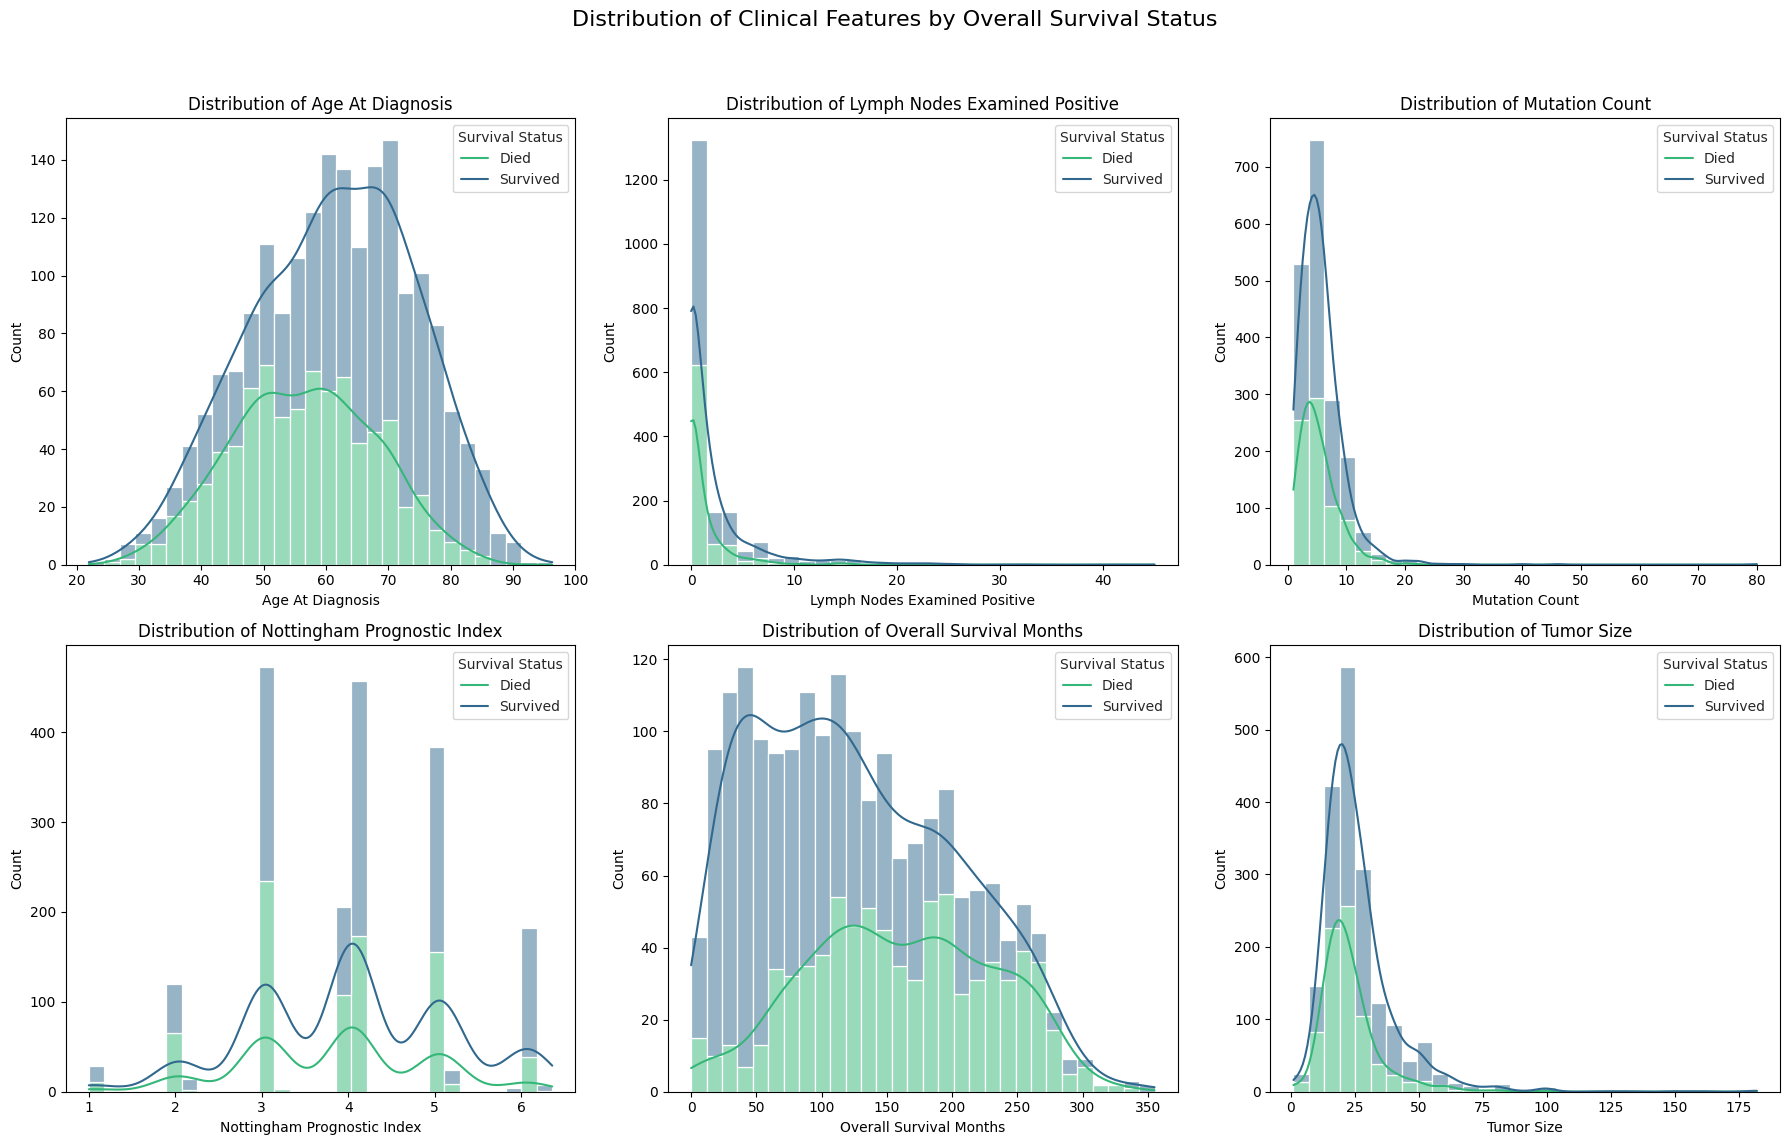

In [ ]:
# Visualizing the distribution of selected clinical features based on overall survival

columns = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']
fig, axs = plt.subplots(2, 3, figsize=(18, 12)) # Increased figure size for better readability
fig.suptitle('Distribution of Clinical Features by Overall Survival Status', fontsize=16) # More descriptive title

sns.set_style("whitegrid") # Use a different seaborn style

for i, ax in zip(data[columns].columns, axs.flatten()):
    sns.histplot(data=data, x=i, hue='overall_survival', multiple='stack', palette='viridis', ax=ax, kde=True, bins=30) # Use hue for survival status, stack the bars, add KDE for smoother representation, adjust bins
    ax.set_title(f'Distribution of {i.replace("_", " ").title()}', fontsize=12) # Add individual plot titles
    ax.set_xlabel(i.replace("_", " ").title(), fontsize=10) # Improve x-axis labels
    ax.set_ylabel('Count', fontsize=10) # Add y-axis label
    ax.legend(title='Survival Status', labels=['Died', 'Survived']) # Customize legend

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Save the plot
fig.savefig('clinical_features_distribution.png', dpi=300)

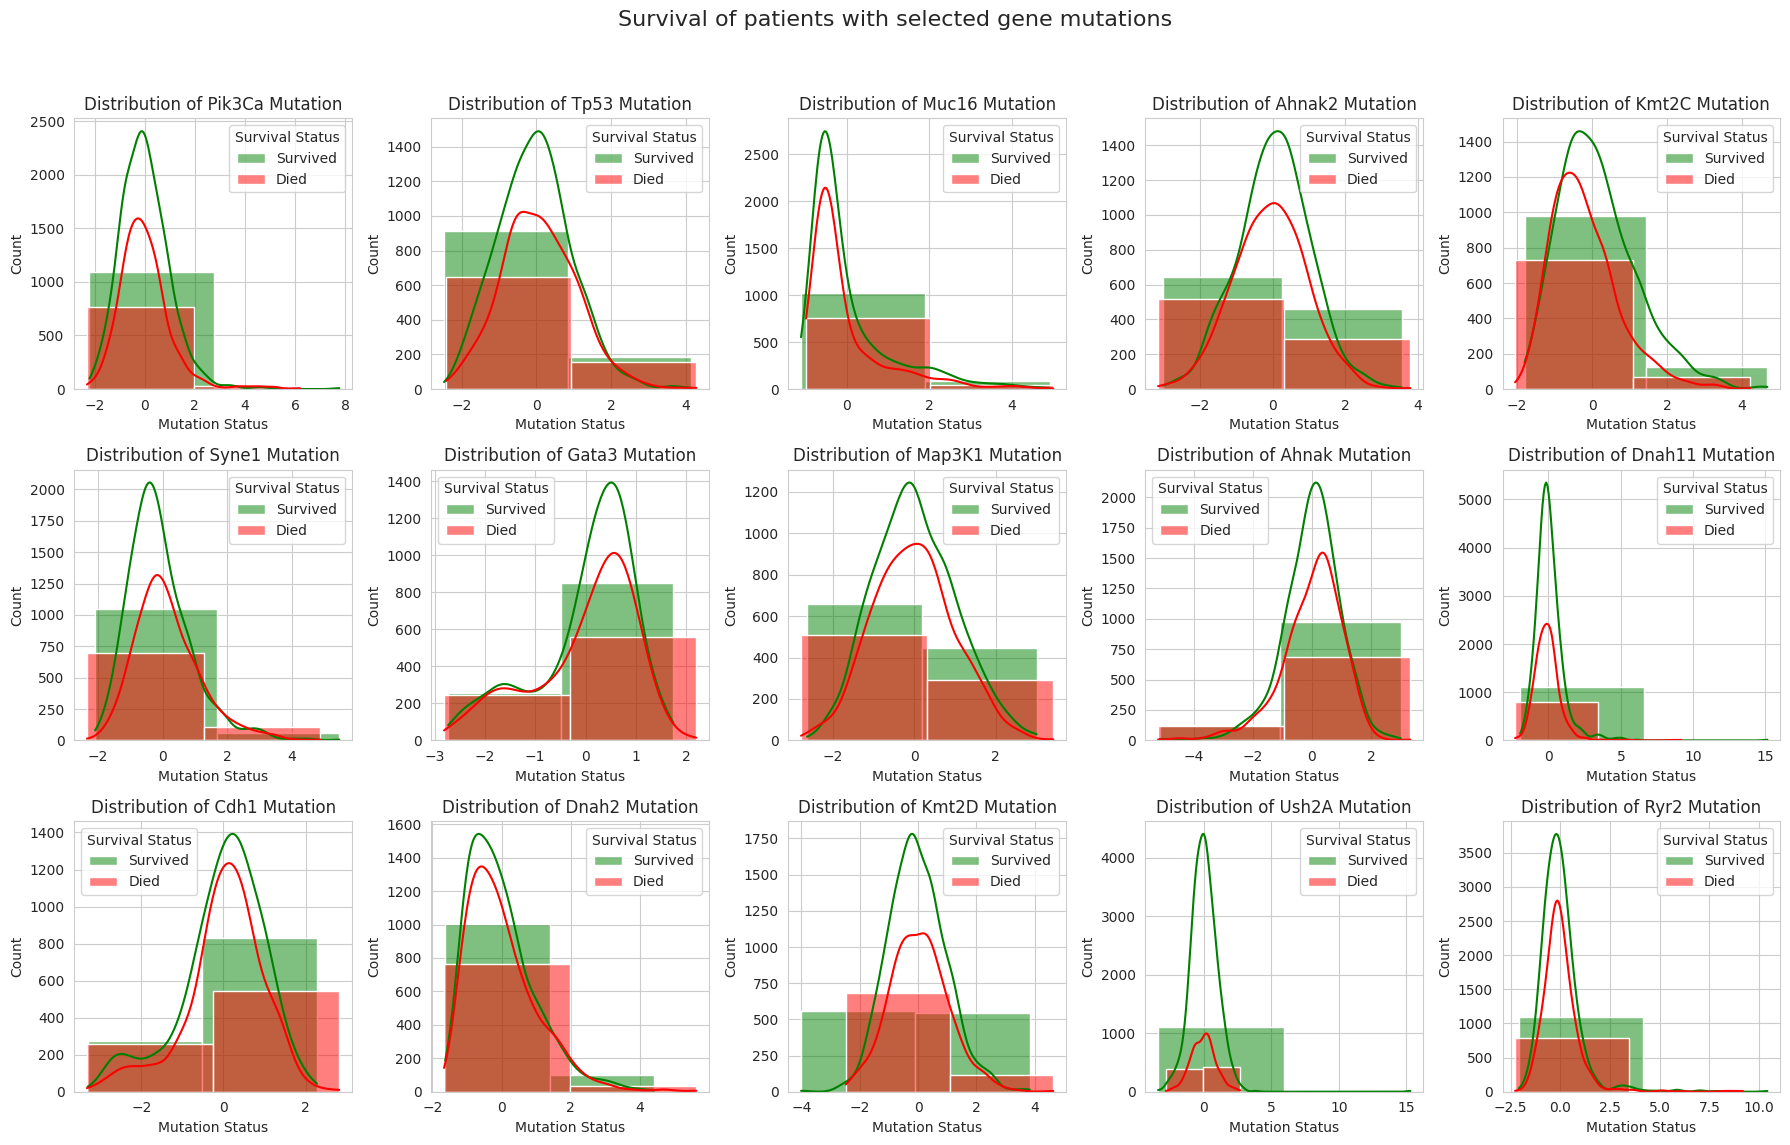

In [ ]:
columns = ['pik3ca','tp53','muc16','ahnak2','kmt2c','syne1','gata3','map3k1','ahnak','dnah11','cdh1','dnah2','kmt2d','ush2a','ryr2']
fig, axs = plt.subplots(3, 5, figsize=(18, 12))
fig.suptitle('Survival of patients with selected gene mutations', fontsize=16)

sns.set_style("whitegrid")

for i,ax in zip(data.loc[:,columns].columns,axs.flatten()):
    sns.histplot(data[i][data['overall_survival']==0], color='g', label = 'Survived',ax=ax, kde=True, bins=2)
    sns.histplot(data[i][data['overall_survival']==1], color='r', label = 'Died',ax=ax, kde=True, bins=2)
    ax.set_title(f'Distribution of {i.replace("_", " ").title()} Mutation', fontsize=12)
    ax.set_xlabel('Mutation Status', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(title='Survival Status', loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plot
fig.savefig('gene_mutation_survival_distribution.png', dpi=300)

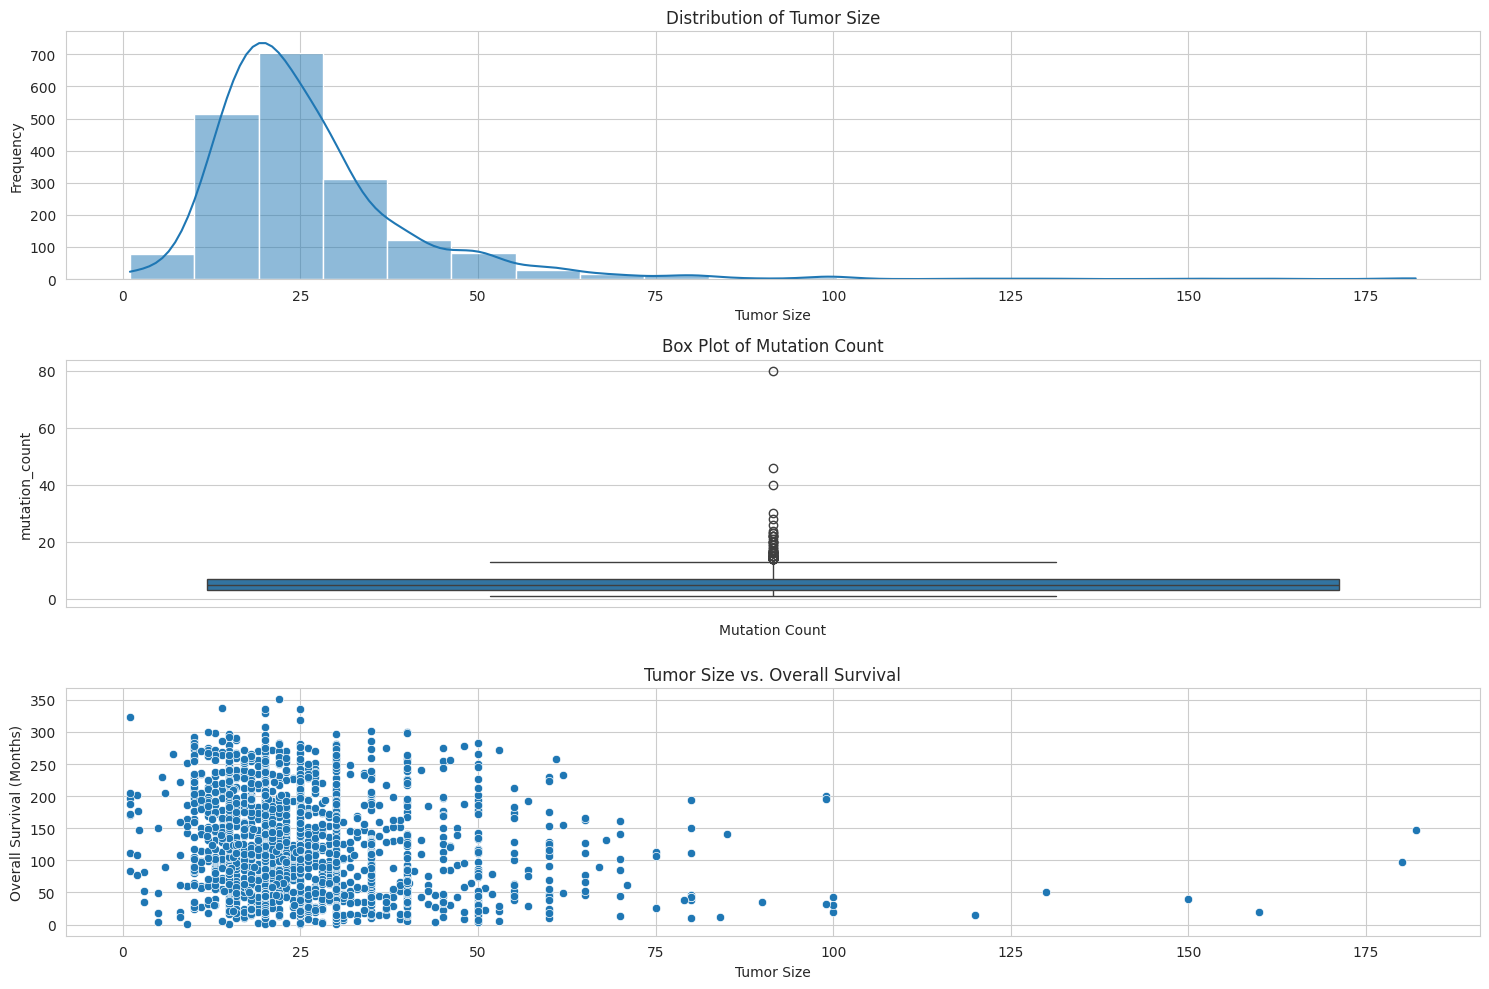

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
sns.histplot(data['tumor_size'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Tumor Size')
axes[0].set_xlabel('Tumor Size')
axes[ 0].set_ylabel('Frequency')

sns.boxplot(data['mutation_count'], ax=axes[1])
axes[1].set_title('Box Plot of Mutation Count')
axes[1].set_xlabel('Mutation Count')

sns.scatterplot(data=data, x='tumor_size', y='overall_survival_months', ax=axes[2])
axes[2].set_title('Tumor Size vs. Overall Survival')
axes[2].set_xlabel('Tumor Size')
axes[2].set_ylabel('Overall Survival (Months)')

plt.tight_layout()
plt.show()

In [ ]:
#Survival Prediction
data_survival = data[data['death_from_cancer'].notnull()].copy()
clinical_data = data_survival[data_survival.columns[:30]].copy()
clinical_data

age_at_diagnosis type_of_breast_surgery    cancer_type  \
0                75.65             MASTECTOMY  Breast Cancer   
1                43.19      BREAST CONSERVING  Breast Cancer   
2                48.87             MASTECTOMY  Breast Cancer   
3                47.68             MASTECTOMY  Breast Cancer   
4                76.97             MASTECTOMY  Breast Cancer   
...                ...                    ...            ...   
1899             43.10      BREAST CONSERVING  Breast Cancer   
1900             42.88             MASTECTOMY  Breast Cancer   
1901             62.90             MASTECTOMY  Breast Cancer   
1902             61.16             MASTECTOMY  Breast Cancer   
1903             60.02      BREAST CONSERVING  Breast Cancer   

                           cancer_type_detailed cellularity  chemotherapy  \
0              Breast Invasive Ductal Carcinoma         NaN             0   
1              Breast Invasive Ductal Carcinoma        High             0   
2              Breast Invasive Ductal Carcinoma        High             1   
3     Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4     Breast Mixed Ductal and Lobular Carcinoma        High             1   
...                                         ...         ...           ...   
1899          Breast Invasive Lobular Carcinoma        High             0   
1900           Breast Invasive Ductal Carcinoma        High             0   
1901           Breast Invasive Ductal Carcinoma        High             0   
1902           Breast Invasive Ductal Carcinoma    Moderate             0   
1903           Breast Invasive Ductal Carcinoma        High             0   

     pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc er_status  \
0                    claudin-low     1.0                   Positve  Positive   
1                           LumA     1.0                   Positve  Positive   
2                           LumB     1.0                   Positve  Positive   
3                           LumB     1.0                   Positve  Positive   
4                           LumB     1.0                   Positve  Positive   
...                          ...     ...                       ...       ...   
1899                        LumA     4.0                   Positve  Positive   
1900                        LumB     4.0                   Positve  Positive   
1901                        LumB     4.0                   Positve  Positive   
1902                        LumB     4.0                   Positve  Positive   
1903                        LumB     4.0                   Positve  Positive   

      ...  nottingham_prognostic_index oncotree_code overall_survival_months  \
0     ...                        6.044           IDC              140.500000   
1     ...                        4.020           IDC               84.633333   
2     ...                        4.030           IDC              163.700000   
3     ...                        4.050          MDLC              164.933333   
4     ...                        6.080          MDLC               41.366667   
...   ...                          ...           ...                     ...   
1899  ...                        5.050           ILC              196.866667   
1900  ...                        5.040           IDC               44.733333   
1901  ...                        6.050           IDC              175.966667   
1902  ...                        5.050           IDC               86.233333   
1903  ...                        5.040           IDC              201.900000   

     overall_survival  pr_status radio_therapy 3-gene_classifier_subtype  \
0                   1   Negative             1                 ER-/HER2-   
1                   1   Positive             1     ER+/HER2- High Prolif   
2                   0   Positive             0                       NaN   
3                   1   Positive             1                       NaN   
4         

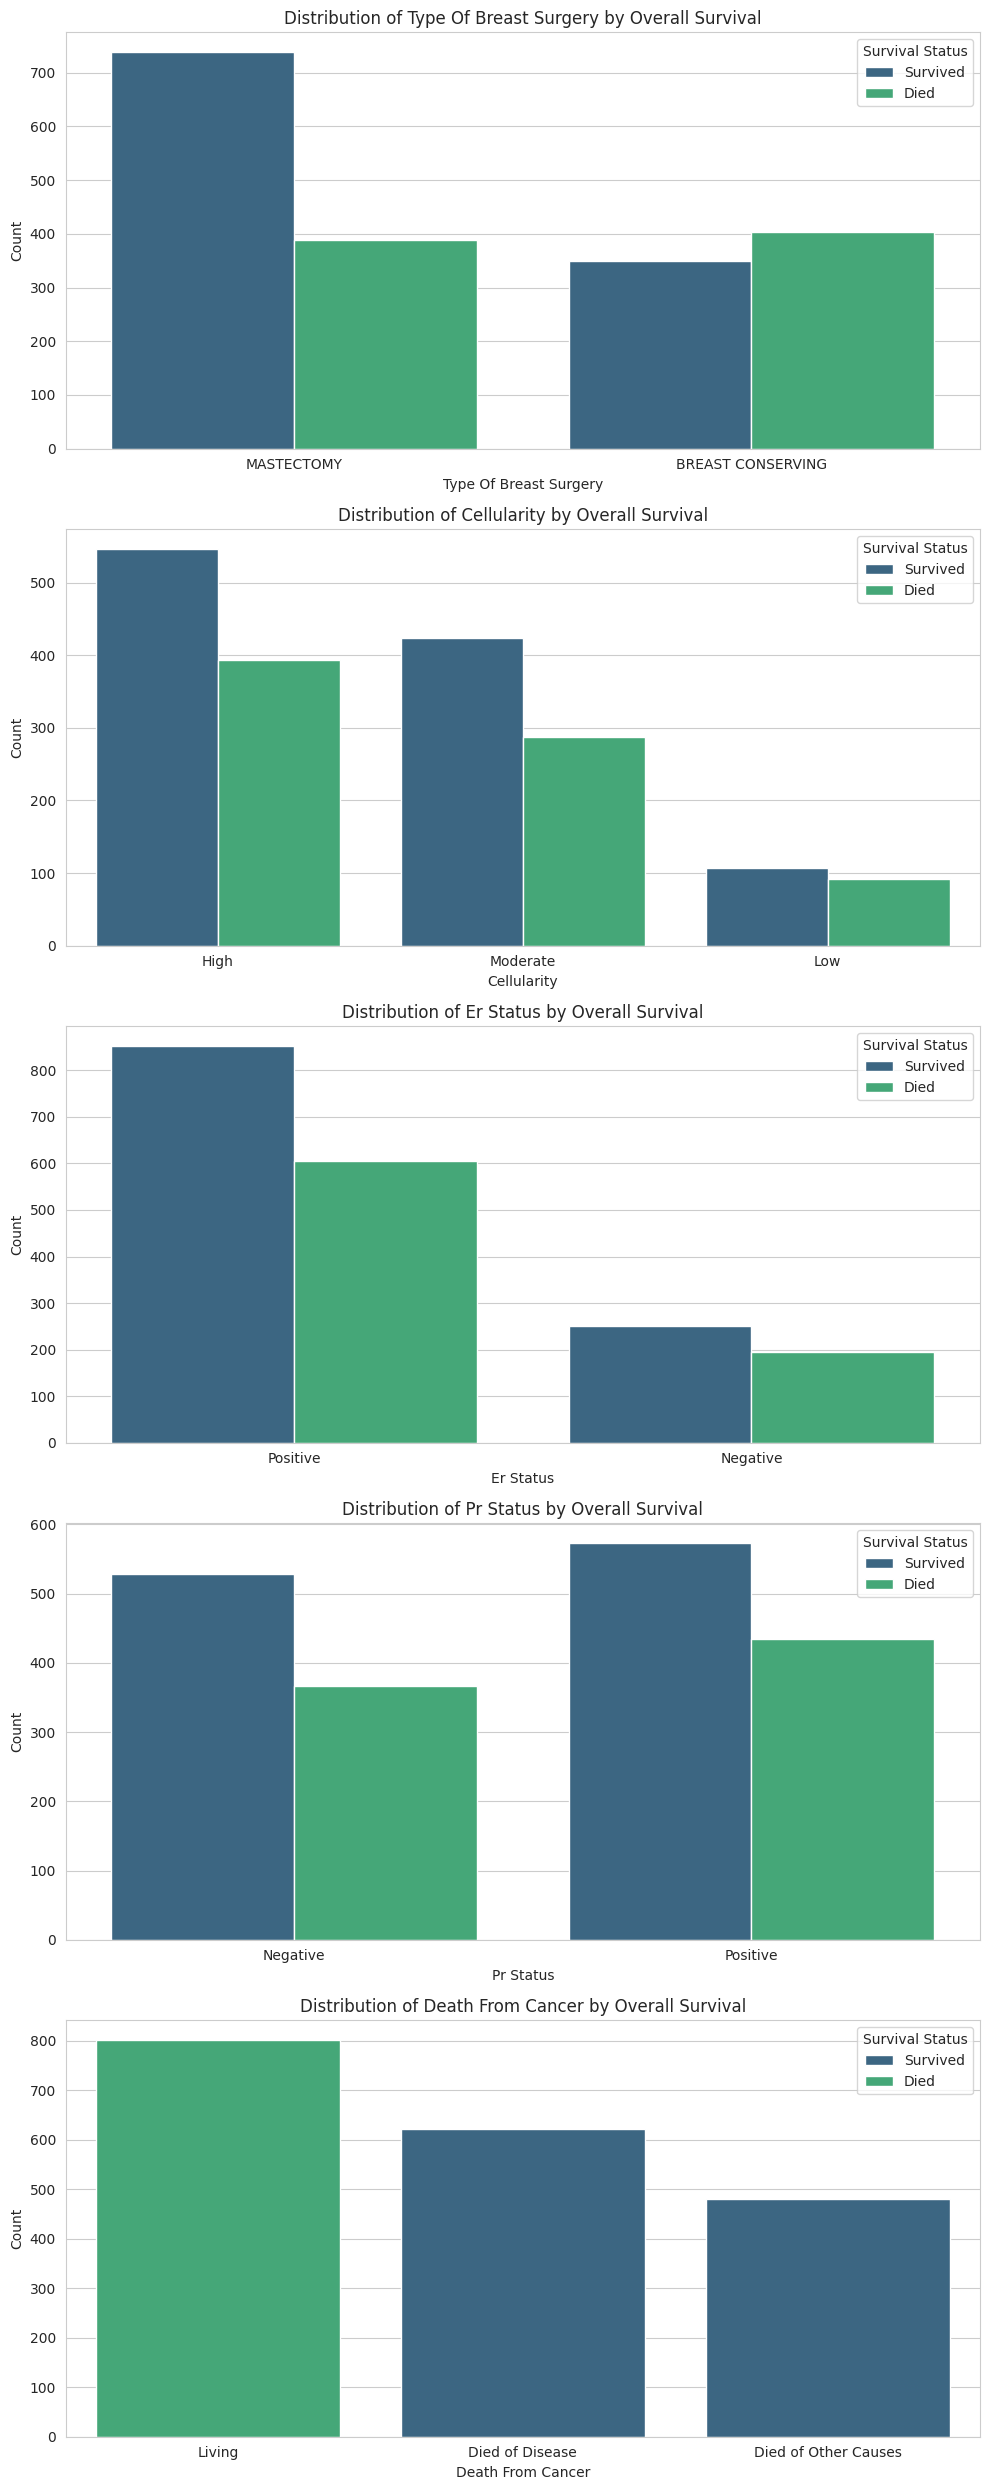

In [ ]:
# Visualize the distribution of some categorical clinical features based on overall survival

categorical_cols = ['type_of_breast_surgery', 'cellularity', 'er_status', 'pr_status', 'death_from_cancer']

fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, 5 * len(categorical_cols))) # Create subplots

for i, col in enumerate(categorical_cols):
    sns.countplot(data=clinical_data, x=col, hue='overall_survival', palette='viridis', ax=axs[i])
    axs[i].set_title(f'Distribution of {col.replace("_", " ").title()} by Overall Survival')
    axs[i].set_xlabel(col.replace("_", " ").title())
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Survival Status', labels=['Survived', 'Died'])

plt.tight_layout()
plt.show()

In [ ]:
encoder = LabelEncoder()
clinical_data['death_from_cancer']=encoder.fit_transform(clinical_data['death_from_cancer'])
clinical_data_encoded = pd.get_dummies(clinical_data)
clinical_data_encoded.columns = [re.sub(r'[!@#$%^&*(){}\[\];:,./<>?\\|`~\=_\']', '_', col) for col in clinical_data_encoded.columns]
clinical_data_encoded.describe()

age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  \
count       1903.000000   1903.000000  1903.000000                1831.000000   
mean          61.088355      0.208092     2.643720                   2.415620   
std           12.981999      0.406050     1.228911                   0.650646   
min           21.930000      0.000000     1.000000                   1.000000   
25%           51.370000      0.000000     1.000000                   2.000000   
50%           61.780000      0.000000     3.000000                   3.000000   
75%           70.595000      0.000000     3.000000                   3.000000   
max           96.290000      1.000000     5.000000                   3.000000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count      1903.000000                    1903.000000     1858.000000   
mean          0.616921                       2.003153        5.693757   
std           0.486265                       4.080807        4.056331   
min           0.000000                       0.000000        1.000000   
25%           0.000000                       0.000000        3.000000   
50%           1.000000                       0.000000        5.000000   
75%           1.000000                       2.000000        7.000000   
max           1.000000                      45.000000       80.000000   

       nottingham_prognostic_index  overall_survival_months  overall_survival  \
count                  1903.000000              1903.000000       1903.000000   
mean                      4.033020               125.053074          0.420914   
std                       1.144792                76.296083          0.493836   
min                       1.000000                 0.000000          0.000000   
25%                       3.046000                60.783333          0.000000   
50%                       4.042000               115.600000          0.000000   
75%                       5.040500               184.550000          1.000000   
max                       6.360000               355.200000          1.000000   

       radio_therapy   tumor_size  tumor_stage  death_from_cancer  
count    1903.000000  1883.000000  1402.000000        1903.000000  
mean        0.596952    26.244695     1.751070           1.094062  
std         0.490639    15.162789     0.628904           0.859830  
min         0.000000     1.000000     0.000000           0.000000  
25%         0.000000    17.000000     1.000000           0.000000  
50%         1.000000    23.000000     2.000000           1.000000  
75%         1.000000    30.000000     2.000000           2.000000  
max         1.000000   182.000000     4.000000           2.000000

In [ ]:
clinical_data_encoded.reset_index(drop=True, inplace=True)
mice_kernel = ImputationKernel(
data = clinical_data_encoded,
random_state = 42
)
mice_kernel.mice(2)
data_full = mice_kernel.complete_data()
data_full.describe()

age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  \
count       1903.000000   1903.000000  1903.000000                1903.000000   
mean          61.088355      0.208092     2.643720                   2.366789   
std           12.981999      0.406050     1.228911                   0.687113   
min           21.930000      0.000000     1.000000                   1.000000   
25%           51.370000      0.000000     1.000000                   2.000000   
50%           61.780000      0.000000     3.000000                   2.000000   
75%           70.595000      0.000000     3.000000                   3.000000   
max           96.290000      1.000000     5.000000                   3.000000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count      1903.000000                    1903.000000     1903.000000   
mean          0.616921                       2.003153        5.631109   
std           0.486265                       4.080807        4.037094   
min           0.000000                       0.000000        1.000000   
25%           0.000000                       0.000000        3.000000   
50%           1.000000                       0.000000        5.000000   
75%           1.000000                       2.000000        7.000000   
max           1.000000                      45.000000       80.000000   

       nottingham_prognostic_index  overall_survival_months  overall_survival  \
count                  1903.000000              1903.000000       1903.000000   
mean                      4.033020               125.053074          0.420914   
std                       1.144792                76.296083          0.493836   
min                       1.000000                 0.000000          0.000000   
25%                       3.046000                60.783333          0.000000   
50%                       4.042000               115.600000          0.000000   
75%                       5.040500               184.550000          1.000000   
max                       6.360000               355.200000          1.000000   

       radio_therapy   tumor_size  tumor_stage  death_from_cancer  
count    1903.000000  1903.000000  1903.000000        1903.000000  
mean        0.596952    26.295197     1.788229           1.094062  
std         0.490639    15.165419     0.613405           0.859830  
min         0.000000     1.000000     0.000000           0.000000  
25%         0.000000    17.000000     1.000000           0.000000  
50%         1.000000    23.000000     2.000000           1.000000  
75%         1.000000    30.000000     2.000000           2.000000  
max         1.000000   182.000000     4.000000           2.000000

In [ ]:
columns_to_keep = data_full.columns != 'death_from_cancer'
X = data_full.loc[:,columns_to_keep]
y = data_full['death_from_cancer']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
def train_models(models, scoring, X, y, cv):
    names = []
    results = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    fit_time_scores = []
    HEADER = '\033[95m'
    WARNING = '\033[90m'
    ENDC = '\033[0m'
    print(HEADER + "Running..."+ENDC)
    for name, model in models:
        result = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        names.append(name)
        results.append(result)
        accuracy_scores.append(result['test_accuracy'].mean())
        precision_scores.append(result['test_precision'].mean())
        recall_scores.append(result['test_recall'].mean())
        f1_scores.append(result['test_f1'].mean())
        roc_auc_scores.append(result['test_roc_auc'].mean())
        fit_time_scores.append(result['fit_time'].sum())
        print(WARNING + f"Progress: {name} finished in {result['fit_time'].sum():.2f} seconds!" + ENDC)
        print(HEADER + "Results:"+ENDC)
        print(f"Accuracy: {accuracy_scores[-1]:.2f}")
        print(f"Precision: {precision_scores[-1]:.2f}")
        print(f"Recall: {recall_scores[-1]:.2f}")
        print(f"F1 Score: {f1_scores[-1]:.2f}")
        print(f"ROC-AUC Score: {roc_auc_scores[-1]:.2f}")
        print(HEADER + "---------------------------------------"+ENDC)
    print(HEADER + "Done!"+ENDC)
    # Plotting
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC','Fit Time']
    scores = [accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores,fit_time_scores]

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Performance Metrics')

    sns.set(style="darkgrid")
    palette = sns.color_palette("dark", n_colors=len(names))

    for i, ax in enumerate(axs.flat):
        sns.barplot(x=names, y=scores[i], hue=names, ax=ax, palette=palette, dodge=False)
        ax.set_title(metrics[i])
        ax.set_ylabel('Score' if i != 5 else 'Seconds')
        ax.set_xlabel('Model')
        ax.set_ylim(0, 1) if i != 5 else None
        ax.grid(True)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    return names, results

Running...
Progress: LogisticRegression finished in 0.66 seconds!
Results:
Accuracy: 0.77
Precision: 0.78
Recall: 0.75
F1 Score: 0.74
ROC-AUC Score: 0.92
---------------------------------------
Progress: RandomForest finished in 2.00 seconds!
Results:
Accuracy: 0.83
Precision: 0.81
Recall: 0.79
F1 Score: 0.79
ROC-AUC Score: 0.94
---------------------------------------
Progress: KNeighbors finished in 0.05 seconds!
Results:
Accuracy: 0.56
Precision: 0.55
Recall: 0.54
F1 Score: 0.54
ROC-AUC Score: 0.72
---------------------------------------
Progress: DecisionTree finished in 0.09 seconds!
Results:
Accuracy: 0.80
Precision: 0.76
Recall: 0.76
F1 Score: 0.76
ROC-AUC Score: 0.85
---------------------------------------
Progress: NaiveBayes finished in 0.04 seconds!
Results:
Accuracy: 0.79
Precision: 0.76
Recall: 0.75
F1 Score: 0.75
ROC-AUC Score: 0.92
---------------------------------------
Done!


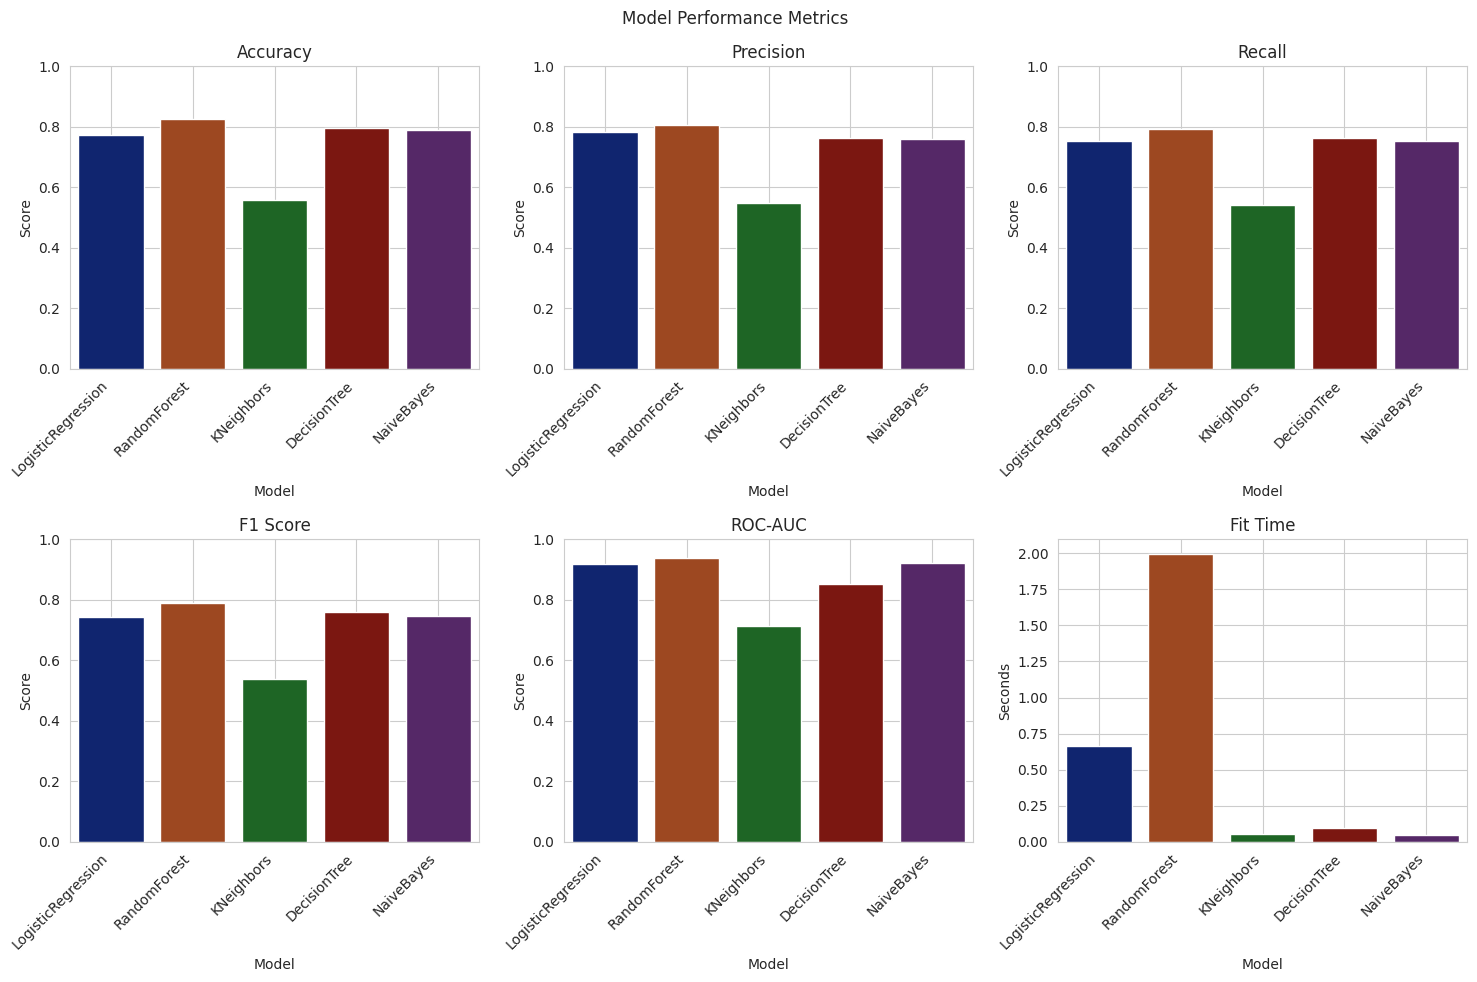

In [ ]:
models = [("LogisticRegression",LogisticRegression()),
         ("RandomForest",RandomForestClassifier(random_state=42,max_depth=10)),
         ("KNeighbors",KNeighborsClassifier()),
         ("DecisionTree",DecisionTreeClassifier(random_state=42,max_depth=10)),
         ("NaiveBayes",GaussianNB())]
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'f1': 'f1_macro',
           'roc_auc': 'roc_auc_ovr'}
names , results = train_models(models=models,scoring=scoring,X=X,y=y,cv=5)

In [ ]:
genetic_data = data_survival[data_survival.columns[30:519]].copy()
genetic_data.isnull().sum().sum()

np.int64(0)

In [ ]:
genetic_data.describe(include='all')

brca1        brca2        palb2         pten         tp53  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.000410     0.001073    -0.001062    -0.000312    -0.000356   
std       1.000364     0.999428     0.999451     1.000433     1.000404   
min      -2.444400    -2.783500    -4.384600    -5.932800    -2.481200   
25%      -0.718300    -0.698550    -0.680250    -0.558900    -0.666200   
50%      -0.124000    -0.057800    -0.023900     0.108700    -0.035200   
75%       0.553250     0.629000     0.638400     0.642750     0.643050   
max       4.554200     3.737900     4.615000     3.254100     4.289800   

               atm         cdh1        chek2          nbn          nf1  ...  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000  ...   
mean      0.001180     0.000214    -0.000290    -0.000263     0.000074  ...   
std       0.999198     1.000483     1.000445     1.000460     1.000519  ...   
min      -3.170500    -3.323700    -2.688700    -3.689800    -2.968600  ...   
25%      -0.658250    -0.459000    -0.738900    -0.667050    -0.684050  ...   
50%      -0.003200     0.115800    -0.131600    -0.014900    -0.053700  ...   
75%       0.690400     0.650100     0.539600     0.639450     0.669450  ...   
max       3.824200     2.820900     4.538200     5.371300     6.178600  ...   

            srd5a1       srd5a2       srd5a3          st7         star  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.000170     0.000363     0.000606    -0.000203    -0.000633   
std       1.000499     1.000399     1.000174     1.000486     1.000146   
min      -2.120800    -3.364800    -2.719400    -4.982700    -2.981700   
25%      -0.618900    -0.609900    -0.673350    -0.614050    -0.633200   
50%      -0.245400    -0.046400    -0.141800    -0.052000    -0.028000   
75%       0.330700     0.515400     0.514800     0.578950     0.590150   
max       6.534900    10.270300     6.329000     4.571300    12.742300   

              tnk2        tulp4     ugt2b15      ugt2b17       ugt2b7  
count  1903.000000  1903.000000  1903.00000  1903.000000  1903.000000  
mean     -0.000451    -0.000325     0.00013     0.000169    -0.000377  
std       1.000332     1.000424     1.00051     1.000498     1.000390  
min      -3.833300    -3.609300    -1.16690    -2.112600    -1.051600  
25%      -0.666550    -0.710300    -0.50585    -0.476500    -0.726000  
50%       0.000200    -0.030100    -0.28860    -0.133400    -0.426200  
75%       0.641850     0.595050     0.06025     0.270950     0.422000  
max       3.938800     3.833400    10.88490    12.643900     3.284400  

[8 rows x 489 columns]

Running...
Progress: LogisticRegression finished in 3.35 seconds!
Results:
Accuracy: 0.38
Precision: 0.37
Recall: 0.37
F1 Score: 0.36
ROC-AUC Score: 0.54
---------------------------------------
Progress: RandomForest finished in 24.09 seconds!
Results:
Accuracy: 0.42
Precision: 0.41
Recall: 0.38
F1 Score: 0.35
ROC-AUC Score: 0.59
---------------------------------------
Progress: KNeighbors finished in 0.10 seconds!
Results:
Accuracy: 0.39
Precision: 0.37
Recall: 0.36
F1 Score: 0.35
ROC-AUC Score: 0.55
---------------------------------------
Progress: DecisionTree finished in 7.95 seconds!
Results:
Accuracy: 0.38
Precision: 0.37
Recall: 0.36
F1 Score: 0.36
ROC-AUC Score: 0.51
---------------------------------------
Progress: NaiveBayes finished in 0.16 seconds!
Results:
Accuracy: 0.41
Precision: 0.43
Recall: 0.42
F1 Score: 0.39
ROC-AUC Score: 0.60
---------------------------------------
Done!


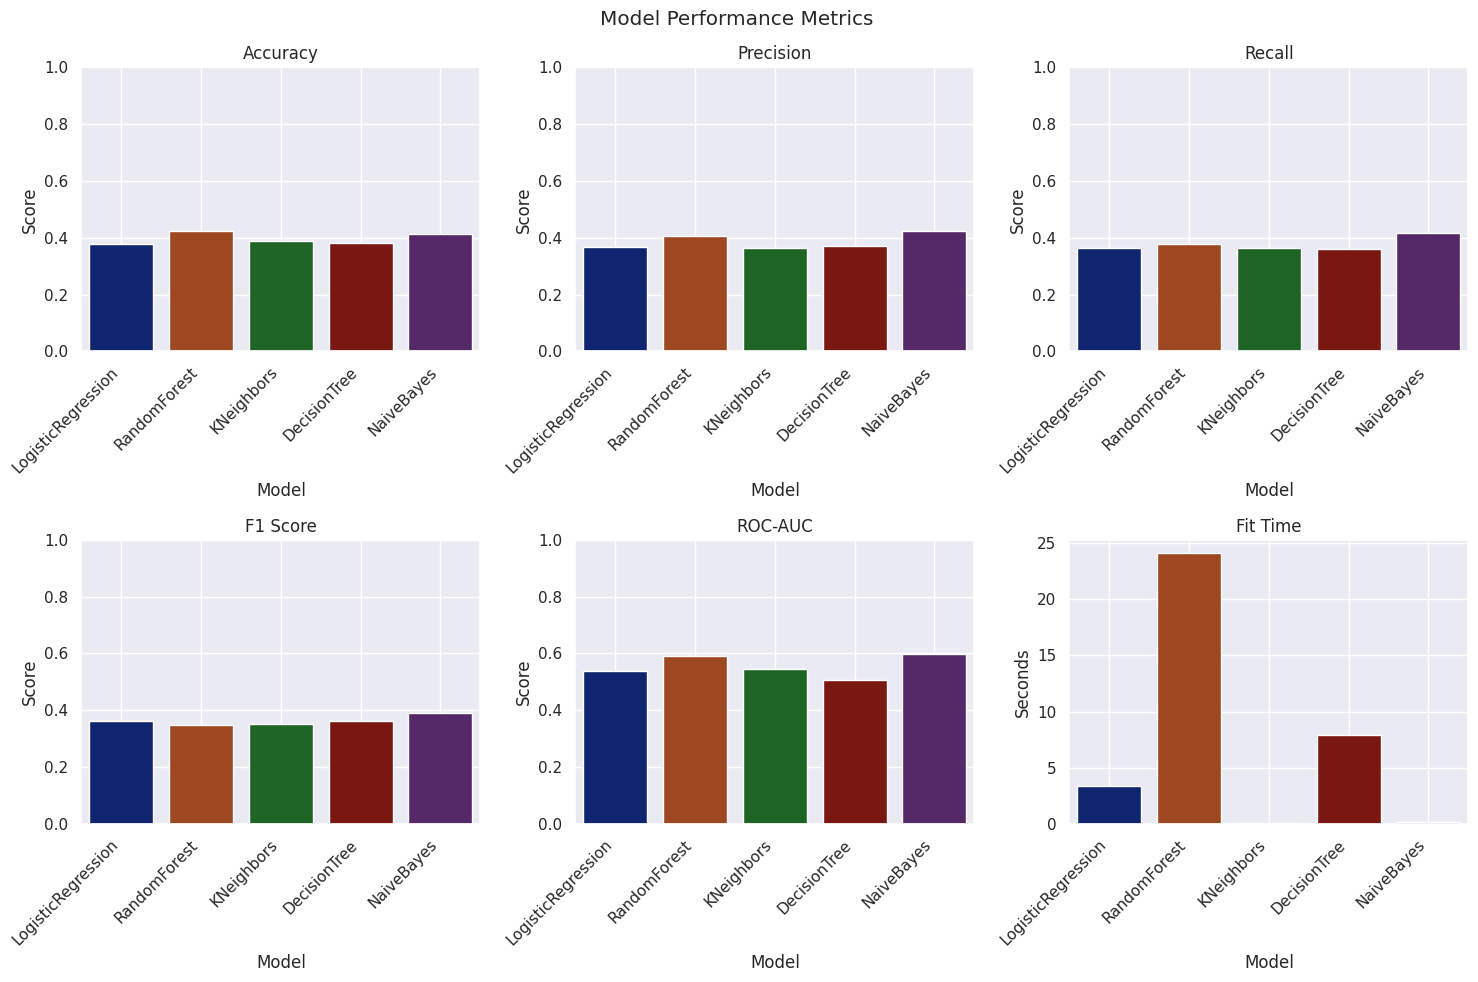

In [ ]:
models = [("LogisticRegression",LogisticRegression()),
         ("RandomForest",RandomForestClassifier(random_state=42,max_depth=10)),
         ("KNeighbors",KNeighborsClassifier()),
         ("DecisionTree",DecisionTreeClassifier(random_state=42,max_depth=10)),
         ("NaiveBayes",GaussianNB())]
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'f1': 'f1_macro',
           'roc_auc': 'roc_auc_ovr'}
names , results = train_models(models=models,scoring=scoring,X=genetic_data,y=y,cv=5)

In [ ]:
# Separate the target variable from data_full
X_clinical_imputed = data_full.drop('death_from_cancer', axis=1)

# Reset the index of genetic_data to align with the imputed clinical data
genetic_data_aligned = genetic_data.reset_index(drop=True)

# Concatenate the imputed clinical data features and the genetic data
merged_data = pd.concat([X_clinical_imputed, genetic_data_aligned], axis=1)

display(merged_data.describe(include='all'))

age_at_diagnosis  chemotherapy       cohort  \
count        1903.000000   1903.000000  1903.000000   
unique               NaN           NaN          NaN   
top                  NaN           NaN          NaN   
freq                 NaN           NaN          NaN   
mean           61.088355      0.208092     2.643720   
std            12.981999      0.406050     1.228911   
min            21.930000      0.000000     1.000000   
25%            51.370000      0.000000     1.000000   
50%            61.780000      0.000000     3.000000   
75%            70.595000      0.000000     3.000000   
max            96.290000      1.000000     5.000000   

        neoplasm_histologic_grade  hormone_therapy  \
count                 1903.000000      1903.000000   
unique                        NaN              NaN   
top                           NaN              NaN   
freq                          NaN              NaN   
mean                     2.366789         0.616921   
std                      0.687113         0.486265   
min                      1.000000         0.000000   
25%                      2.000000         0.000000   
50%                      2.000000         1.000000   
75%                      3.000000         1.000000   
max                      3.000000         1.000000   

        lymph_nodes_examined_positive  mutation_count  \
count                     1903.000000     1903.000000   
unique                            NaN             NaN   
top                               NaN             NaN   
freq                              NaN             NaN   
mean                         2.003153        5.631109   
std                          4.080807        4.037094   
min                          0.000000        1.000000   
25%                          0.000000        3.000000   
50%                          0.000000        5.000000   
75%                          2.000000        7.000000   
max                         45.000000       80.000000   

        nottingham_prognostic_index  overall_survival_months  \
count                   1903.000000              1903.000000   
unique                          NaN                      NaN   
top                             NaN                      NaN   
freq                            NaN                      NaN   
mean                       4.033020               125.053074   
std                        1.144792                76.296083   
min                        1.000000                 0.000000   
25%                        3.046000                60.783333   
50%                        4.042000               115.600000   
75%                        5.040500               184.550000   
max                        6.360000               355.200000   

        overall_survival  ...       srd5a1       srd5a2       srd5a3  \
count        1903.000000  ...  1903.000000  1903.000000  1903.000000   
unique               NaN  ...          NaN          NaN          NaN   
top                  NaN  ...          NaN          NaN          NaN   
freq                 NaN  ...          NaN          NaN          NaN   
mean            0.420914  ...     0.000170     0.000363     0.000606   
std             0.493836  ...     1.000499     1.000399     1.000174   
min             0.000000  ...    -2.120800    -3.364800    -2.719400   
25%             0.000000  ...    -0.618900    -0.609900    -0.673350   
50%             0.000000  ...    -0.245400    -0.046400    -0.141800   
75%             1.000000  ...     0.330700     0.515400     0.514800   
max             1.000000  ...     6.534900    10.270300     6.329000   

                st7         star         tnk2        tulp4     ugt2b15  \
count   1903.000000  1903.000000  1903.000000  1903.000000  1903.00000   
unique          NaN          NaN          NaN          NaN         NaN   
top             NaN          NaN          NaN          NaN         NaN   
freq            NaN          NaN          NaN          NaN         NaN   
mean     

Running...
Progress: LogisticRegression finished in 0.63 seconds!
Results:
Accuracy: 0.77
Precision: 0.78
Recall: 0.75
F1 Score: 0.74
ROC-AUC Score: 0.92
---------------------------------------
Progress: RandomForest finished in 2.02 seconds!
Results:
Accuracy: 0.83
Precision: 0.81
Recall: 0.79
F1 Score: 0.79
ROC-AUC Score: 0.94
---------------------------------------
Progress: KNeighbors finished in 0.03 seconds!
Results:
Accuracy: 0.56
Precision: 0.55
Recall: 0.54
F1 Score: 0.54
ROC-AUC Score: 0.72
---------------------------------------
Progress: DecisionTree finished in 0.09 seconds!
Results:
Accuracy: 0.80
Precision: 0.76
Recall: 0.76
F1 Score: 0.76
ROC-AUC Score: 0.85
---------------------------------------
Progress: NaiveBayes finished in 0.04 seconds!
Results:
Accuracy: 0.79
Precision: 0.76
Recall: 0.75
F1 Score: 0.75
ROC-AUC Score: 0.92
---------------------------------------
Done!


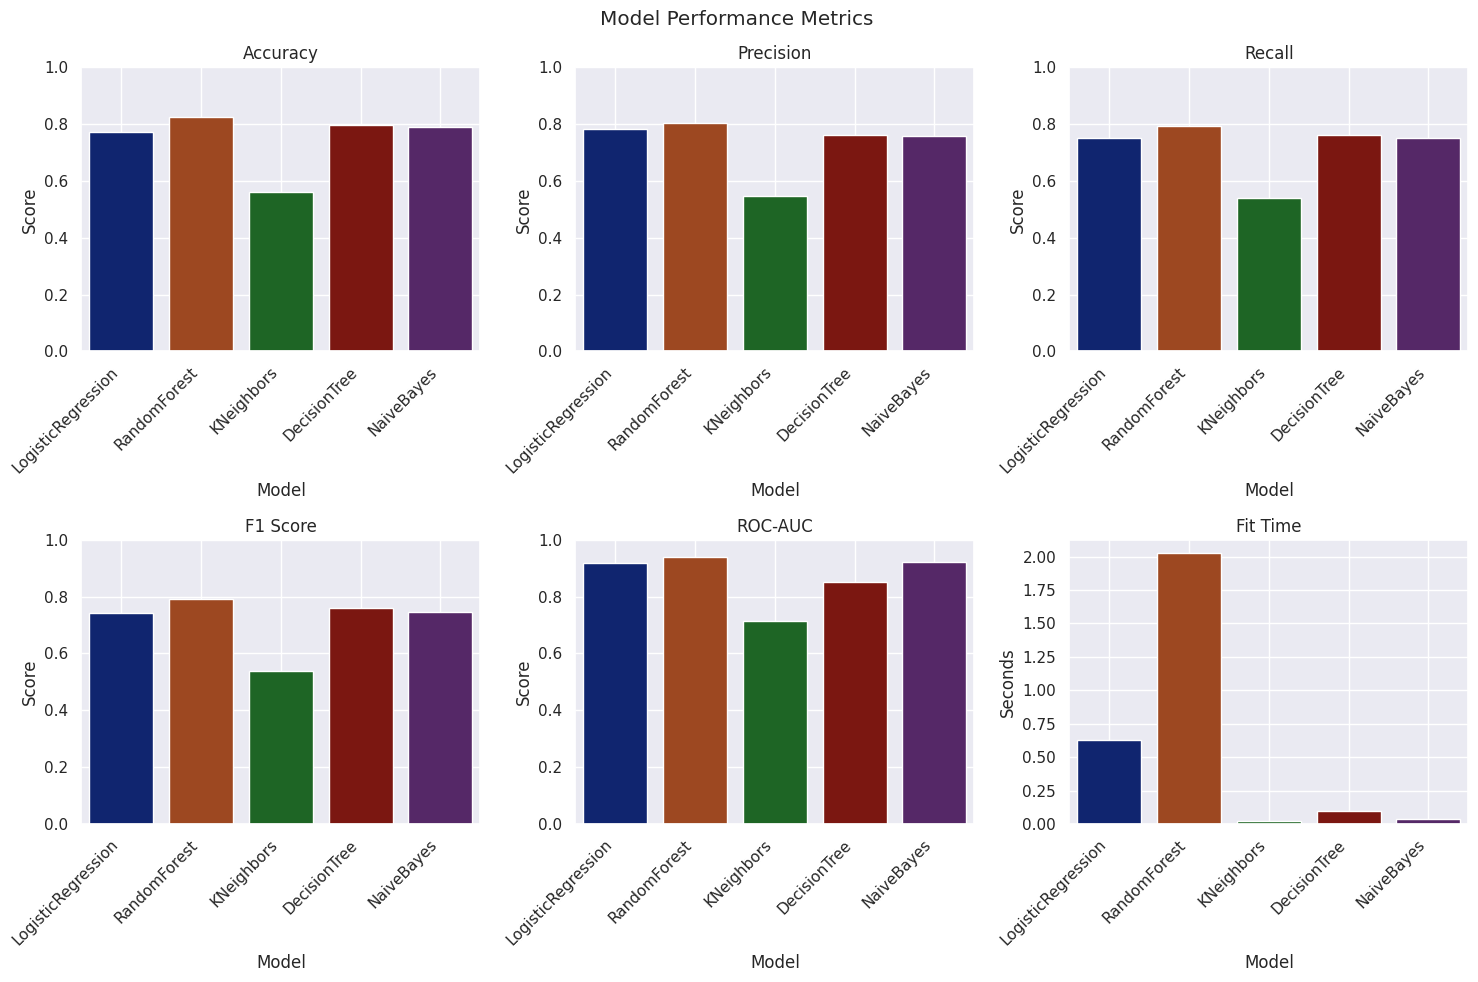

In [ ]:
# Drop rows with NaN in the target variable
X = X[y.notna()]
y = y.dropna()

models = [("LogisticRegression",LogisticRegression()),
         ("RandomForest",RandomForestClassifier(random_state=42,max_depth=10)),
         ("KNeighbors",KNeighborsClassifier()),
         ("DecisionTree",DecisionTreeClassifier(random_state=42,max_depth=10)),
         ("NaiveBayes",GaussianNB())]
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'f1': 'f1_macro',
           'roc_auc': 'roc_auc_ovr'}
names , results = train_models(models=models,scoring=scoring,X=X,y=y,cv=5)

In [ ]:
#XGBoost
X_train_XGB = xgb.DMatrix(X_train, label=y_train)
X_test_XGB = xgb.DMatrix(X_test, label=y_test)

In [ ]:
param_grid = {
    'eta': [0.1, 0.25, 0.5, 0.75, 1],
    'max_depth': [3, 6, 9],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

model_xgb = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)

precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
accuracy = accuracy_score(y_test, preds)

print("Best Parameters:", best_params)
print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("Accuracy = {}".format(accuracy))

Best Parameters: {'colsample_bytree': 0.6, 'eta': 0.1, 'gamma': 0.1, 'max_depth': 3, 'subsample': 0.8}
Precision = 0.8319000819000819
Recall = 0.8221242986828482
Accuracy = 0.8398950131233596


In [ ]:
#Survivial Predition with Neural Network
X_train = X_train.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from math import exp

def exponential_decay(epoch, lr):
    k = 0.003
    interval = 20
    if epoch % interval == 0 and epoch > 0:
        new_lr = lr * exp(-k * epoch)
        return new_lr
    else:
        return lr


lr = LearningRateScheduler(exponential_decay)
early_stopping = EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(78,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=200,batch_size=10,callbacks=[early_stopping,lr])

Epoch 1/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3504 - loss: 8.3736 - val_accuracy: 0.5302 - val_loss: 1.4632 - learning_rate: 1.0000e-04
Epoch 2/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4804 - loss: 2.0465 - val_accuracy: 0.5669 - val_loss: 1.2969 - learning_rate: 1.0000e-04
Epoch 3/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5243 - loss: 1.8246 - val_accuracy: 0.5853 - val_loss: 1.1153 - learning_rate: 1.0000e-04
Epoch 4/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4930 - loss: 1.7007 - val_accuracy: 0.5722 - val_loss: 1.1437 - learning_rate: 1.0000e-04
Epoch 5/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5258 - loss: 1.5977 - val_accuracy: 0.5722 - val_loss: 1.1672 - learning_rate: 1.0000e-04
Epoch 6/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5280 - loss: 1.5359 - val_accuracy: 0.5879 - val_loss: 0.9449 - learning_rate: 1.0000e-04
Epoch 7/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

In [ ]:
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8299 - loss: 0.3329 


[0.32392582297325134, 0.8267716765403748]

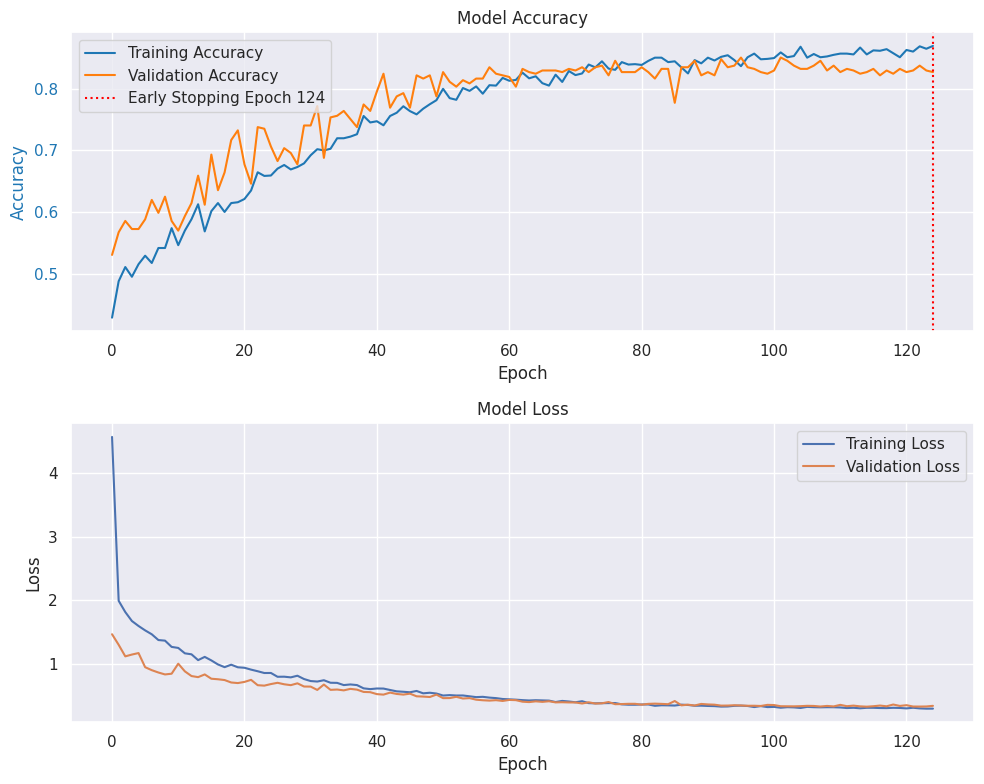

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
ax1 = axes[0]
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='tab:blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
ax1.set_title('Model Accuracy') # Removed Learning Rate from title
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Removed the twin axis for Learning Rate plotting as 'lr' key is not available
# ax2 = ax1.twinx()
# ax2.plot(history.history['lr'], label='Learning Rate', color='tab:green', linestyle='--')
# ax2.set_ylabel('Learning Rate', color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='upper right')

# Add vertical line for Early Stopping
if early_stopping.stopped_epoch > 0:
    # Early stopping epoch is 1-based in the history object
    stopped_epoch_index = early_stopping.stopped_epoch
    ax1.axvline(x=stopped_epoch_index, color='red', linestyle=':', label=f'Early Stopping Epoch {early_stopping.stopped_epoch}')
    ax1.legend(loc='upper left') # Update legend to include early stopping line


# Plot Loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

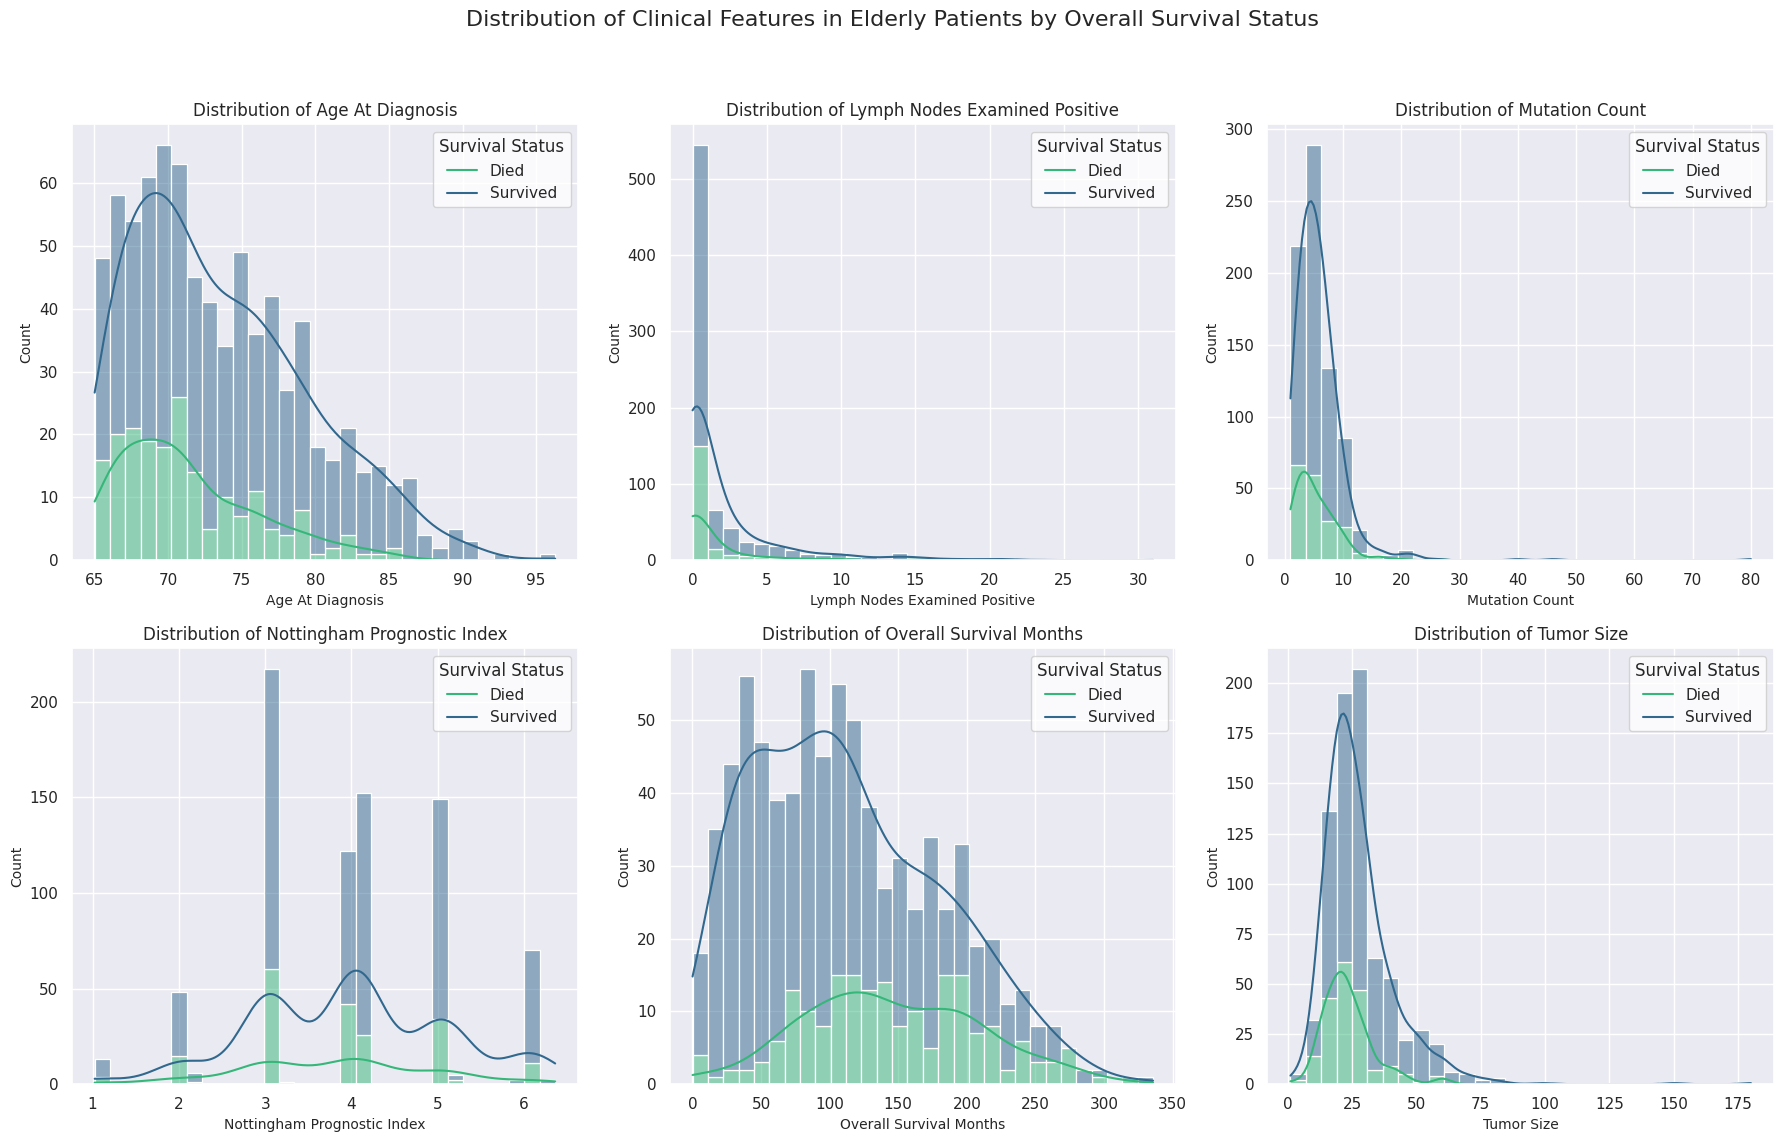

In [ ]:
# Research 1: Survival analysis in elderly patients

# Define elderly as age at diagnosis >= 65
elderly_patients = clinical_data_encoded[clinical_data_encoded['age_at_diagnosis'] >= 65].copy()

# Separate features and target for elderly patients
X_elderly_clinical = elderly_patients.drop('death_from_cancer', axis=1)
y_elderly = elderly_patients['death_from_cancer']

# Visualize the distribution of some clinical features in elderly patients based on overall survival
clinical_cols_elderly = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Clinical Features in Elderly Patients by Overall Survival Status', fontsize=16)

sns.set_style("whitegrid")

for i, ax in zip(elderly_patients[clinical_cols_elderly].columns, axs.flatten()):
    sns.histplot(data=elderly_patients, x=i, hue='overall_survival', multiple='stack', palette='viridis', ax=ax, kde=True, bins=30)
    ax.set_title(f'Distribution of {i.replace("_", " ").title()}', fontsize=12)
    ax.set_xlabel(i.replace("_", " ").title(), fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(title='Survival Status', labels=['Died', 'Survived'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plot
fig.savefig('elderly_clinical_features_distribution.png', dpi=300)

Running...
Progress: LogisticRegression finished in 0.40 seconds!
Results:
Accuracy: 0.64
Precision: 0.70
Recall: 0.66
F1 Score: 0.64
ROC-AUC Score: 0.84
---------------------------------------
Progress: RandomForest finished in 1.49 seconds!
Results:
Accuracy: 0.74
Precision: 0.78
Recall: 0.76
F1 Score: 0.75
ROC-AUC Score: 0.88
---------------------------------------
Progress: KNeighbors finished in 0.02 seconds!
Results:
Accuracy: 0.47
Precision: 0.45
Recall: 0.43
F1 Score: 0.42
ROC-AUC Score: 0.64
---------------------------------------
Progress: DecisionTree finished in 0.06 seconds!
Results:
Accuracy: 0.72
Precision: 0.76
Recall: 0.75
F1 Score: 0.75
ROC-AUC Score: 0.81
---------------------------------------
Progress: NaiveBayes finished in 0.03 seconds!
Results:
Accuracy: 0.69
Precision: 0.73
Recall: 0.72
F1 Score: 0.72
ROC-AUC Score: 0.84
---------------------------------------
Done!


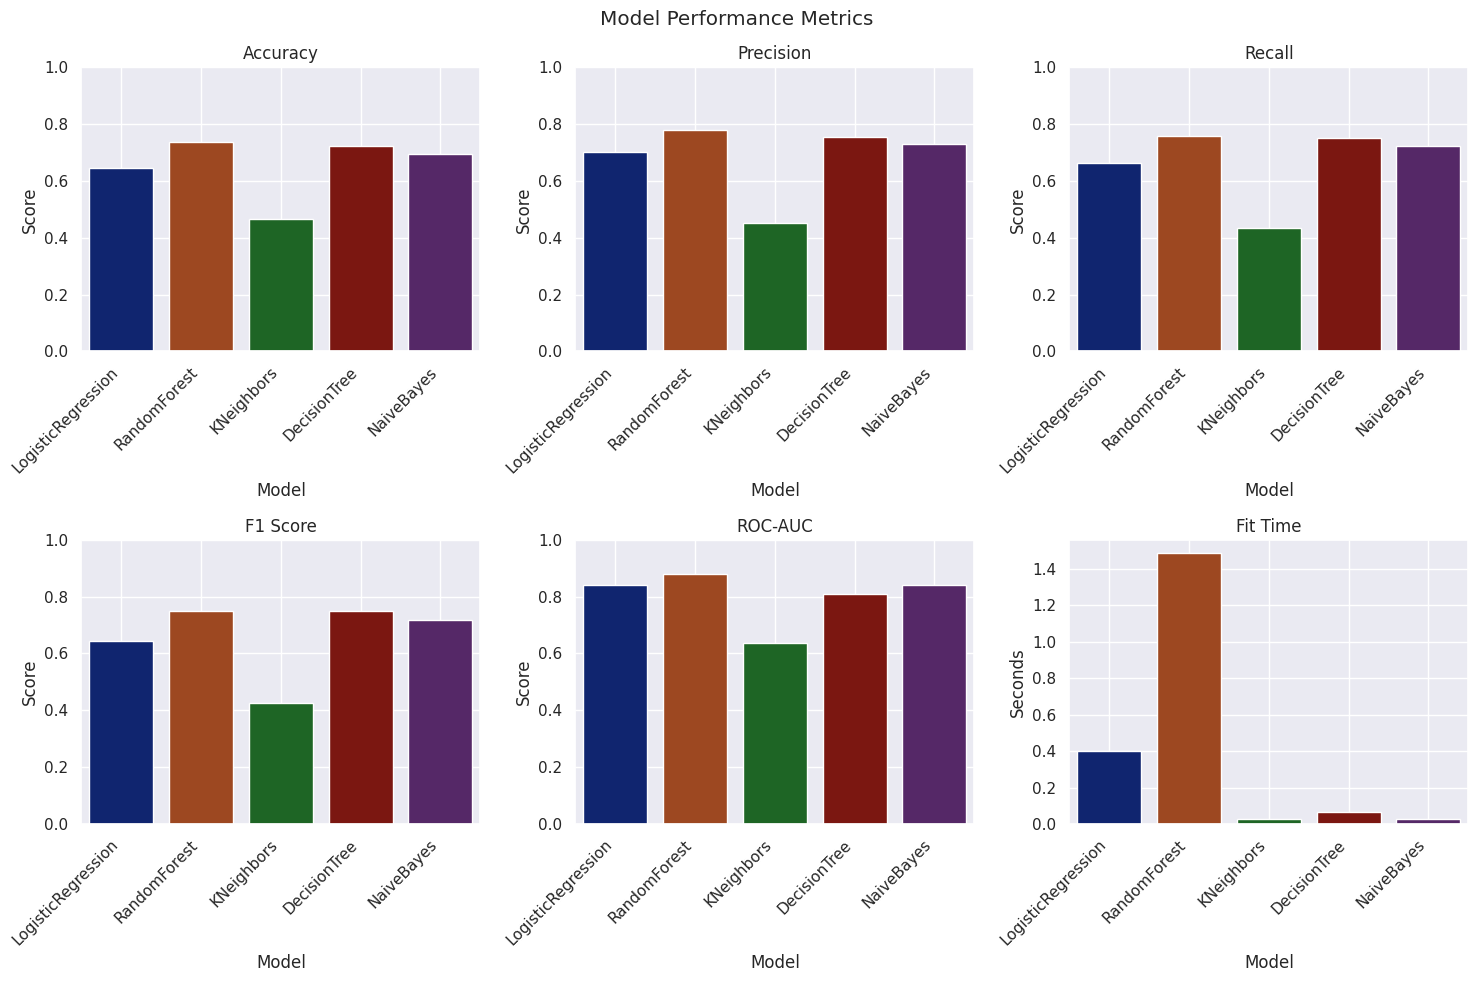

In [ ]:
# Research 2: Survival prediction for elderly patients using clinical and genetic data

# Impute missing values in elderly_patients using MICE
# Reset index before passing to ImputationKernel
elderly_patients.reset_index(drop=True, inplace=True)
mice_kernel_elderly = ImputationKernel(
    data=elderly_patients,
    random_state=42
)
mice_kernel_elderly.mice(2)
elderly_data_full = mice_kernel_elderly.complete_data()

# Separate features and target for the full elderly dataset
X_elderly = elderly_data_full.drop('death_from_cancer', axis=1)
y_elderly = elderly_data_full['death_from_cancer']

# Split data for model training
X_train_elderly, X_test_elderly, y_train_elderly, y_test_elderly = train_test_split(X_elderly, y_elderly, test_size=0.2, random_state=42)

# Train and evaluate models on elderly data
models_elderly = [
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier(random_state=42, max_depth=10)),
    ("KNeighbors", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier(random_state=42, max_depth=10)),
    ("NaiveBayes", GaussianNB())
]

scoring_elderly = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'
}

names_elderly, results_elderly = train_models(
    models=models_elderly,
    scoring=scoring_elderly,
    X=X_elderly,
    y=y_elderly,
    cv=5
)

In [ ]:
young_patients = clinical_data_encoded[clinical_data_encoded['age_at_diagnosis'] < 65].copy()

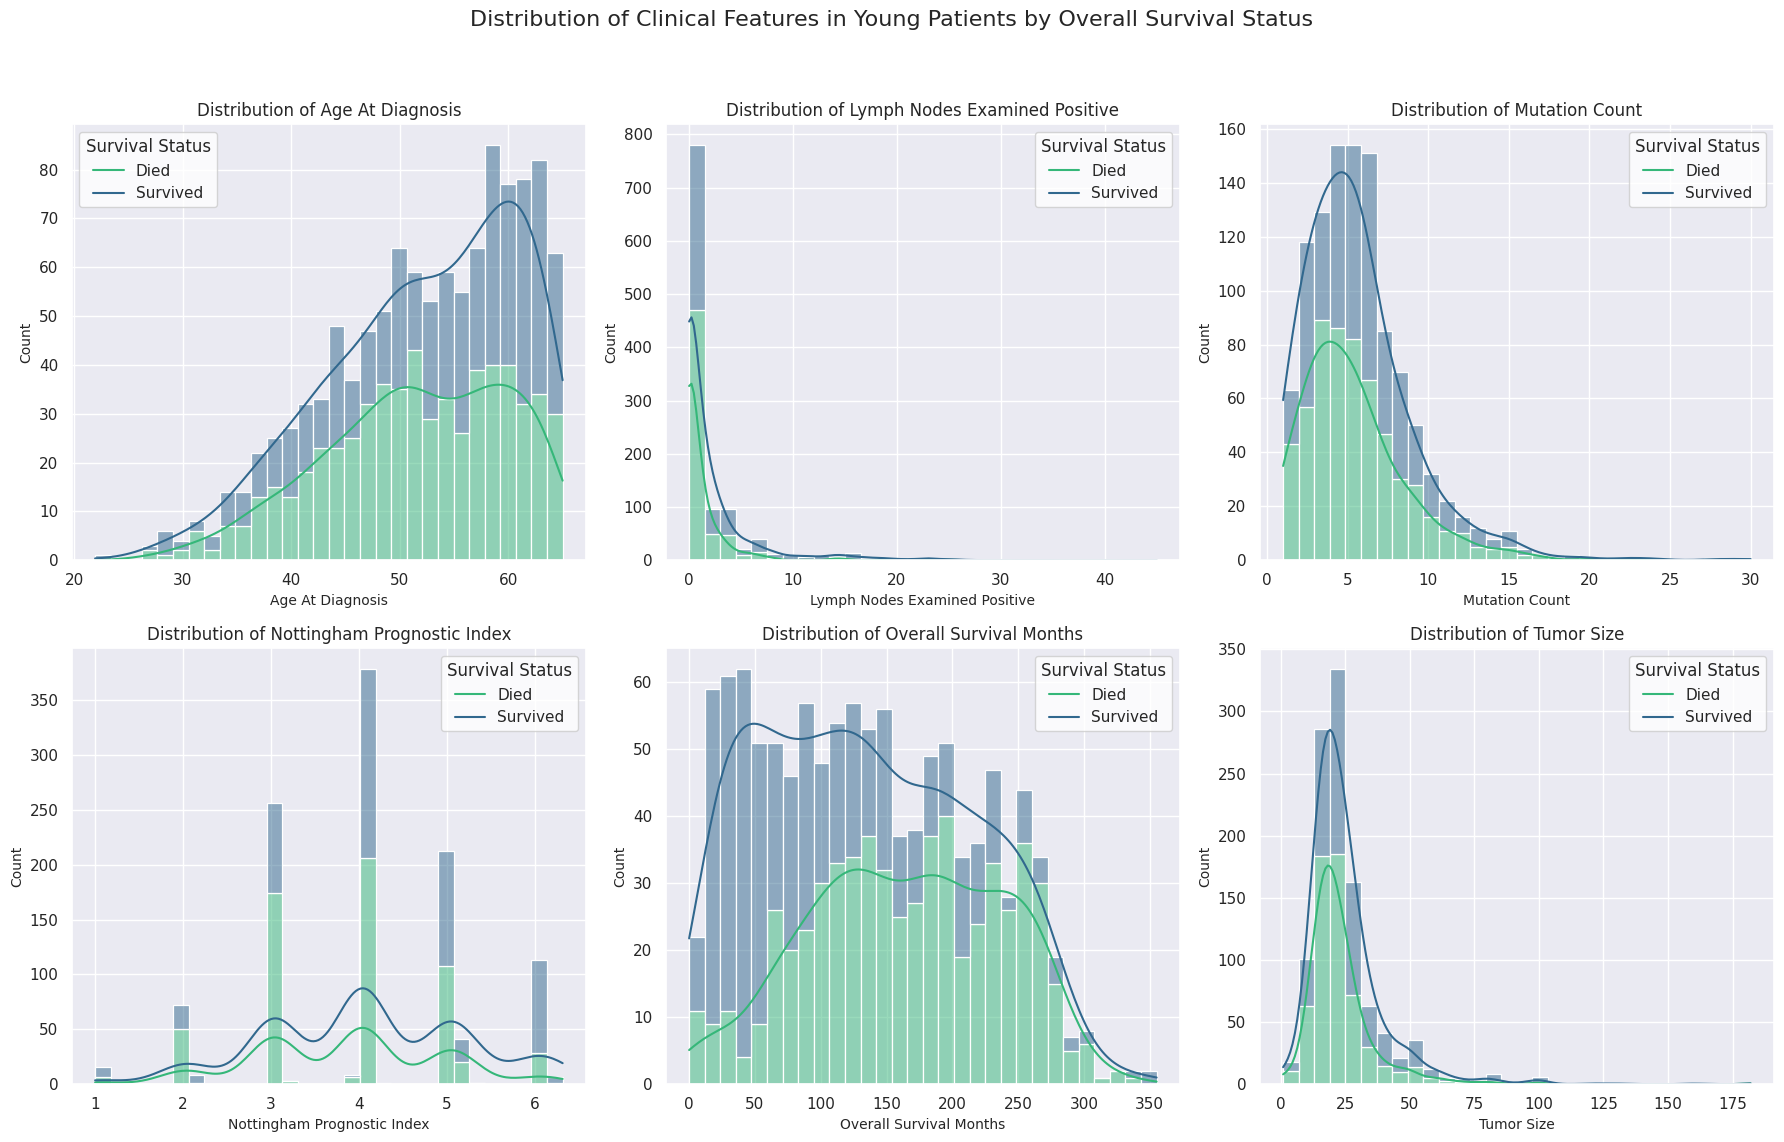

In [ ]:
# Select the specified clinical columns for young patients
clinical_cols_young = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Clinical Features in Young Patients by Overall Survival Status', fontsize=16)

sns.set_style("whitegrid")

# Iterate through columns and create histograms
for i, ax in zip(young_patients[clinical_cols_young].columns, axs.flatten()):
    sns.histplot(data=young_patients, x=i, hue='overall_survival', multiple='stack', palette='viridis', ax=ax, kde=True, bins=30)
    ax.set_title(f'Distribution of {i.replace("_", " ").title()}', fontsize=12)
    ax.set_xlabel(i.replace("_", " ").title(), fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(title='Survival Status', labels=['Died', 'Survived'])

# Adjust layout and display plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plot
fig.savefig('young_clinical_features_distribution.png', dpi=300)

In [ ]:
young_patients.reset_index(drop=True, inplace=True)
mice_kernel_young = ImputationKernel(
    data=young_patients,
    random_state=42
)
mice_kernel_young.mice(2)
young_data_full = mice_kernel_young.complete_data()
display(young_data_full.describe())

age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  \
count       1116.000000   1116.000000  1116.000000                1116.000000   
mean          52.326774      0.323477     2.541219                   2.407706   
std            8.765993      0.468013     1.189304                   0.693010   
min           21.930000      0.000000     1.000000                   1.000000   
25%           46.370000      0.000000     1.000000                   2.000000   
50%           53.620000      0.000000     3.000000                   3.000000   
75%           59.842500      1.000000     3.000000                   3.000000   
max           64.990000      1.000000     5.000000                   3.000000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count      1116.000000                    1116.000000     1116.000000   
mean          0.535842                       2.032258        5.500896   
std           0.498937                       4.323970        3.433807   
min           0.000000                       0.000000        1.000000   
25%           0.000000                       0.000000        3.000000   
50%           1.000000                       0.000000        5.000000   
75%           1.000000                       2.000000        7.000000   
max           1.000000                      45.000000       30.000000   

       nottingham_prognostic_index  overall_survival_months  overall_survival  \
count                  1116.000000              1116.000000       1116.000000   
mean                      4.074121               134.512545          0.543011   
std                       1.152374                80.442005          0.498370   
min                       1.000000                 0.000000          0.000000   
25%                       3.046000                63.825000          0.000000   
50%                       4.040000               128.183333          1.000000   
75%                       5.044000               198.358333          1.000000   
max                       6.320000               355.200000          1.000000   

       radio_therapy   tumor_size  tumor_stage  death_from_cancer  
count    1116.000000  1116.000000  1116.000000        1116.000000  
mean        0.653226    25.244319     1.731183           1.212366  
std         0.476156    15.484932     0.620541           0.910659  
min         0.000000     1.000000     0.000000           0.000000  
25%         0.000000    16.000000     1.000000           0.000000  
50%         1.000000    21.000000     2.000000           2.000000  
75%         1.000000    30.000000     2.000000           2.000000  
max         1.000000   182.000000     4.000000           2.000000

In [ ]:
X_young = young_data_full.drop('death_from_cancer', axis=1)
y_young = young_data_full['death_from_cancer']

X_train_young, X_test_young, y_train_young, y_test_young = train_test_split(X_young, y_young, test_size=0.2, random_state=42)

Running...
Progress: LogisticRegression finished in 0.46 seconds!
Results:
Accuracy: 0.84
Precision: 0.77
Recall: 0.73
F1 Score: 0.73
ROC-AUC Score: 0.93
---------------------------------------
Progress: RandomForest finished in 1.59 seconds!
Results:
Accuracy: 0.88
Precision: 0.82
Recall: 0.74
F1 Score: 0.74
ROC-AUC Score: 0.96
---------------------------------------
Progress: KNeighbors finished in 0.04 seconds!
Results:
Accuracy: 0.65
Precision: 0.53
Recall: 0.51
F1 Score: 0.51
ROC-AUC Score: 0.69
---------------------------------------
Progress: DecisionTree finished in 0.05 seconds!
Results:
Accuracy: 0.86
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
ROC-AUC Score: 0.85
---------------------------------------
Progress: NaiveBayes finished in 0.03 seconds!
Results:
Accuracy: 0.84
Precision: 0.76
Recall: 0.76
F1 Score: 0.74
ROC-AUC Score: 0.95
---------------------------------------
Done!


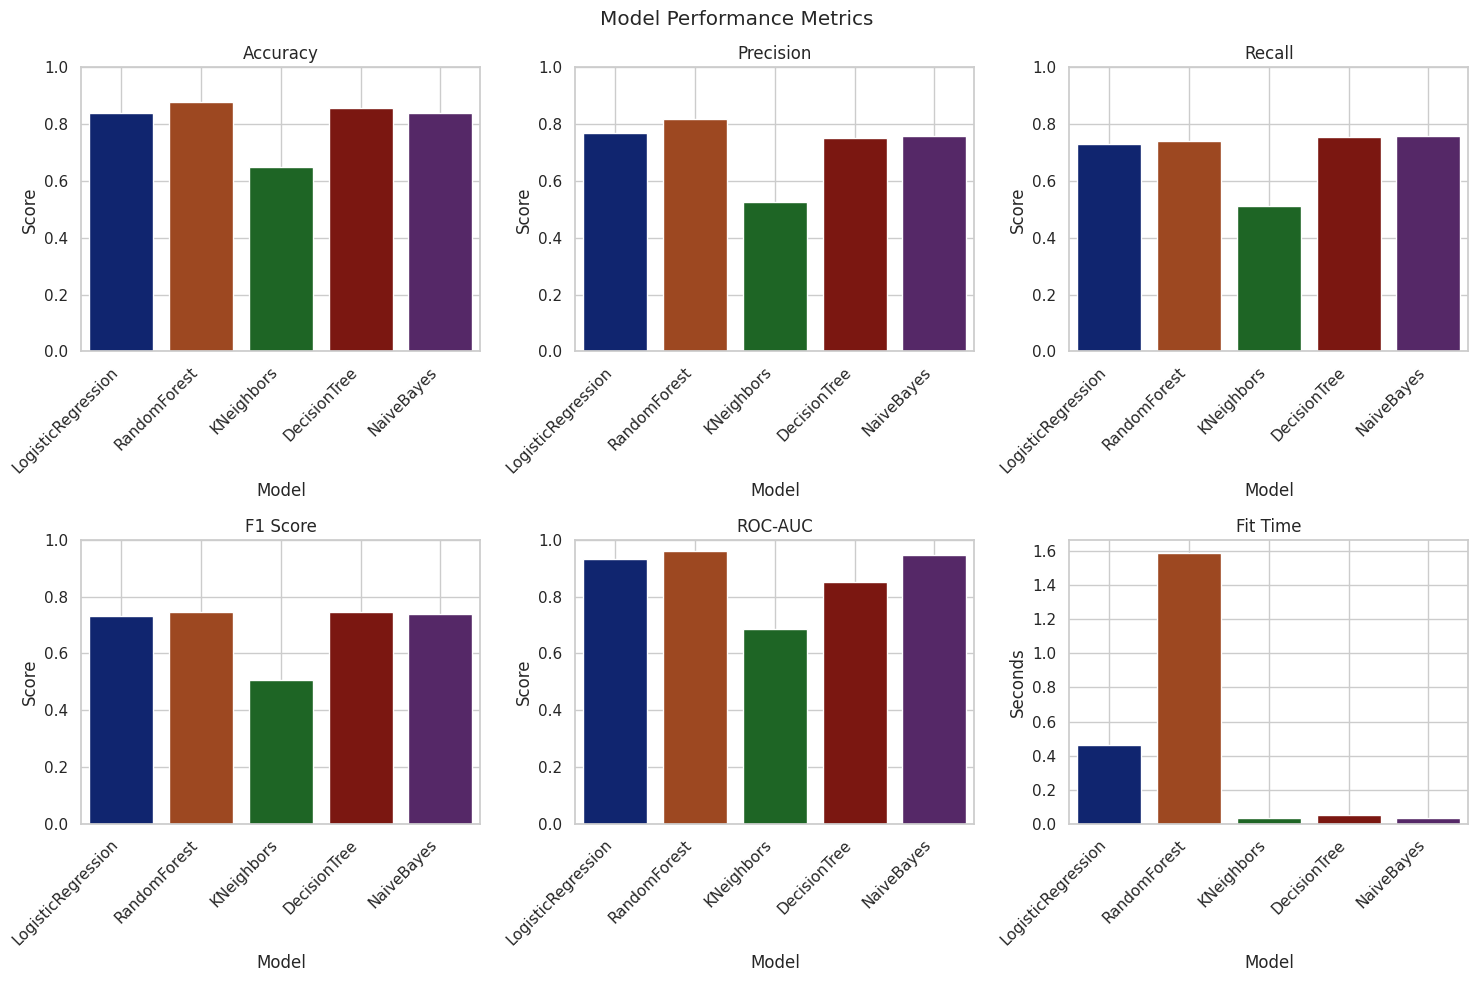

In [ ]:
models_young = [
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier(random_state=42, max_depth=10)),
    ("KNeighbors", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier(random_state=42, max_depth=10)),
    ("NaiveBayes", GaussianNB())
]

scoring_young = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'
}

names_young, results_young = train_models(
    models=models_young,
    scoring=scoring_young,
    X=X_young,
    y=y_young,
    cv=5
)

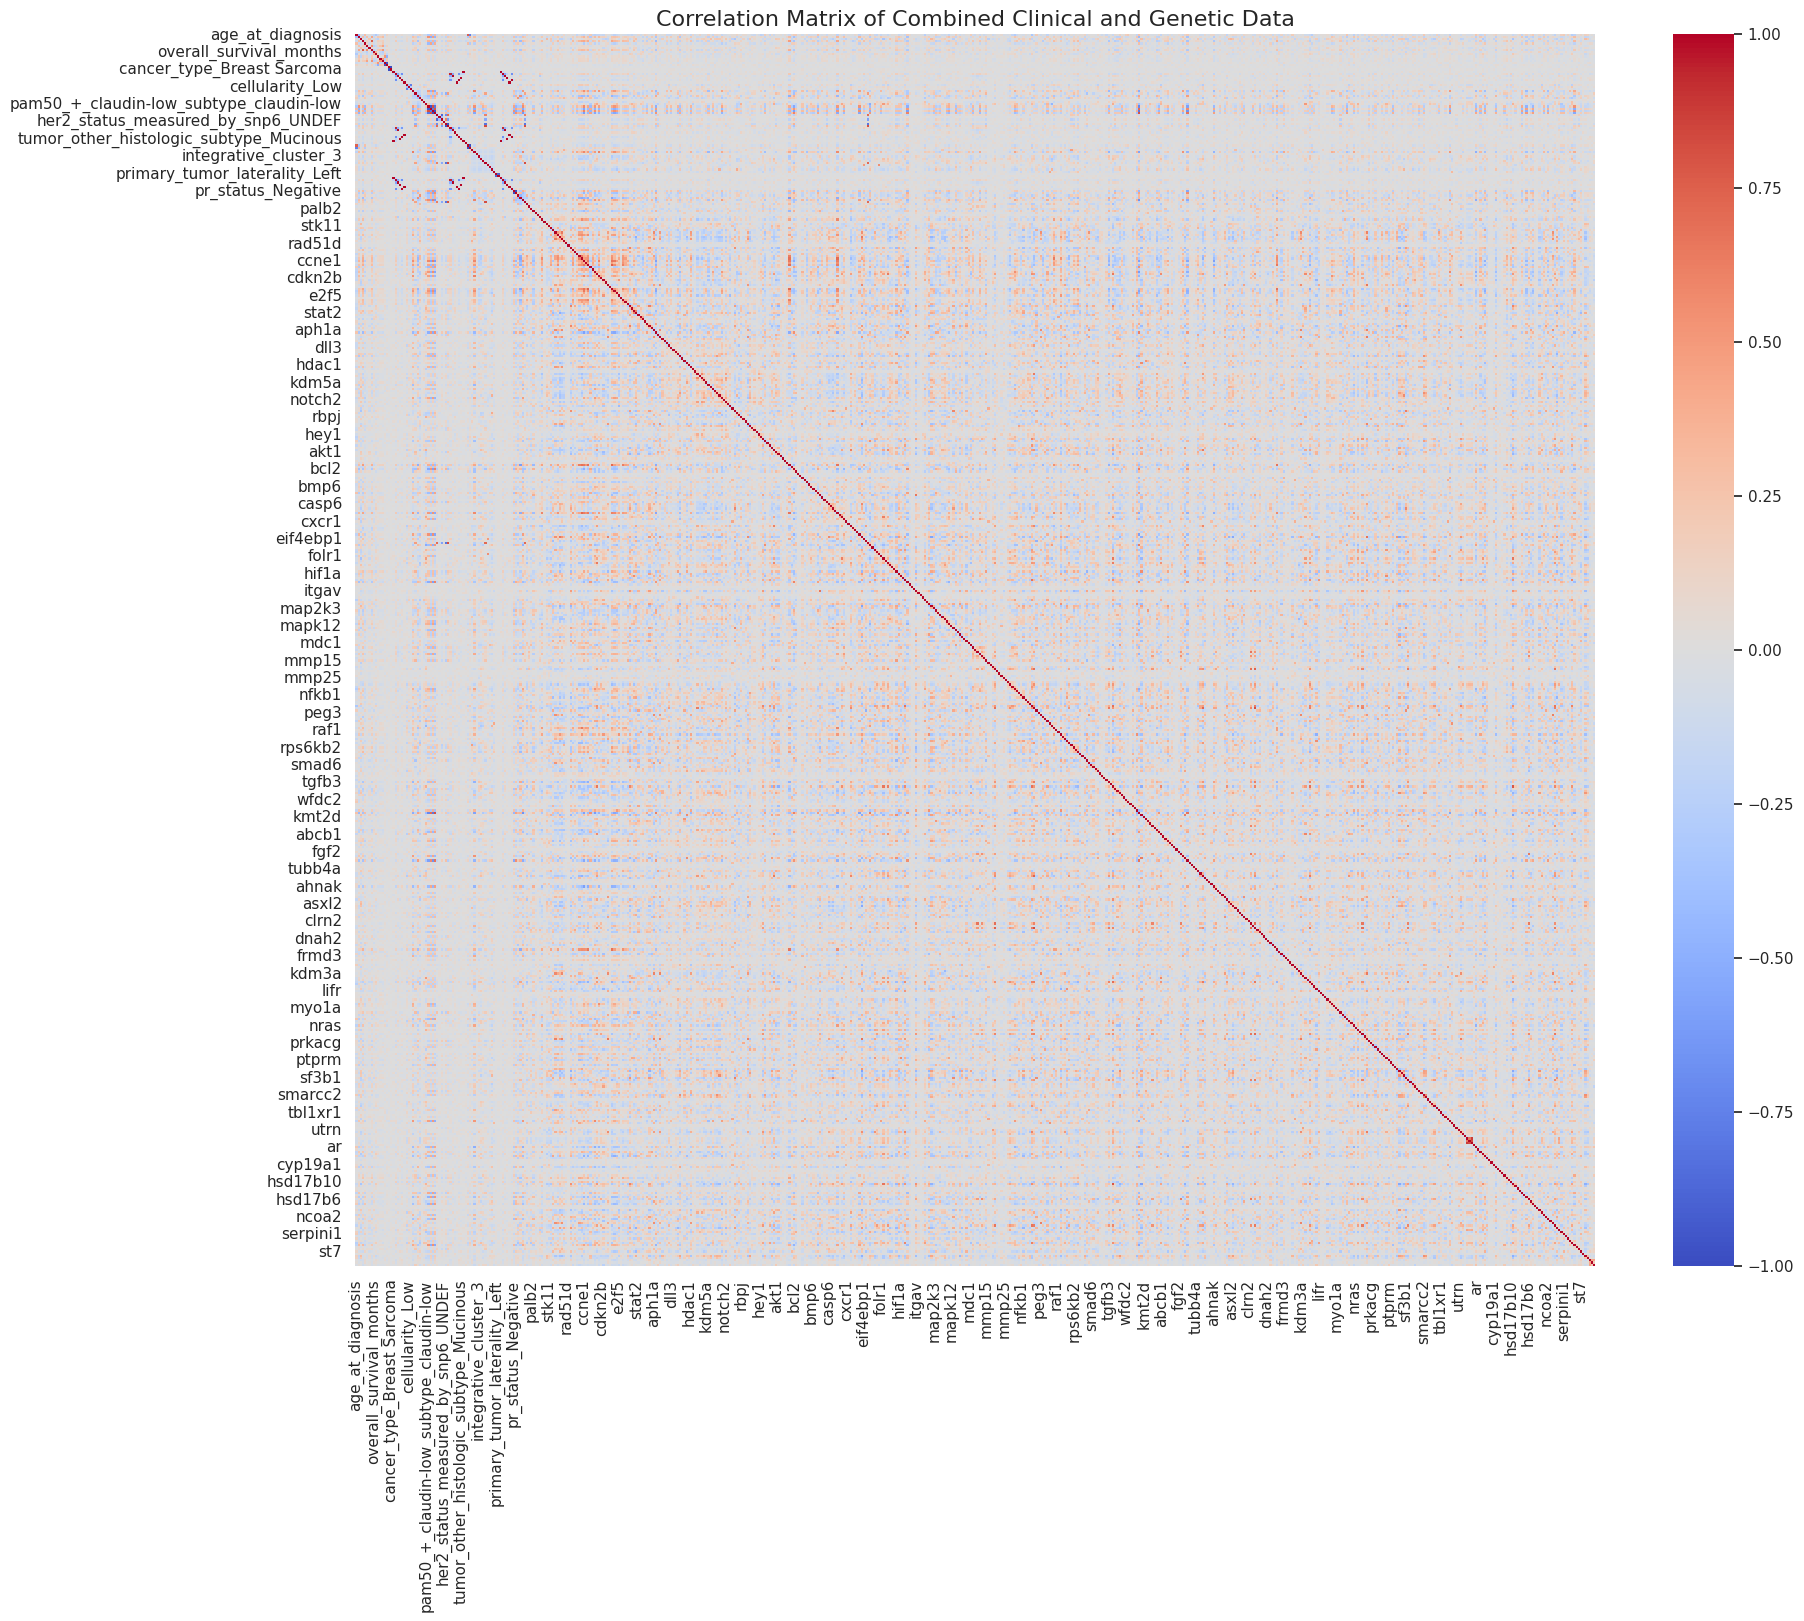

In [ ]:
# Calculate the correlation matrix for the merged_data_full DataFrame
correlation_matrix = merged_data_full.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Combined Clinical and Genetic Data', fontsize=16)
plt.show()